In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
def gauss_kernel(features_i,features_j,kernel_width,dx):
  dns = np.linalg.norm(features_i - features_j, axis=1)**2 * dx #calculate the squares of the L2 norm distances between the feature vectors
  return np.exp(-dns/(2*kernel_width**2))

class KRR_model():
  def __init__(self,kernel_width,regularisation_param):
    self.kernel_width=kernel_width
    self.regularisation_param=regularisation_param
    self.weights = None

  def fit(self,train_features,train_labels,dx):
    self.train_features = train_features
    n_train = len(train_labels)
    kernel_matrix = np.zeros(shape=(n_train,n_train))
    for row in range(n_train):
      kernel_matrix[row,:] = gauss_kernel(train_features[row],train_features[:],self.kernel_width,dx)
    regularised_matrix = kernel_matrix+self.regularisation_param*np.identity(n_train)
    weights = np.matmul(np.linalg.inv(regularised_matrix),train_labels)
    self.weights=weights
    self.RKHS_norm = np.sqrt(np.dot(weights.T, np.matmul(kernel_matrix, weights)))

  def evaluate(self,test_features,test_labels,dx):
    if self.weights is None:
      raise ValueError("Model weights have not been calculated. Use model.fit().")
    if test_features.shape[1] != self.train_features.shape[1]:
      raise ValueError("Feature dimensions do not match.")
    if len(test_features) == 0 or len(test_labels) == 0:
      raise ValueError("Test features or labels are empty.")

    mae=0 #mean absolute error
    n_test = len(test_labels)
    predictions = np.zeros(n_test)
    for j in range(n_test):
        prediction = np.dot(gauss_kernel(test_features[j], self.train_features, self.kernel_width, dx), self.weights)
        predictions[j] = prediction
        error=np.abs(test_labels[j]-prediction)
        mae+=error
    mae/=n_test
    nmae = 100*(mae/np.abs(np.mean(test_labels))) #normalised mean absolute error
    return mae,nmae,predictions

In [ ]:
def k_fold_cross_val(regularisation_parameter,kernel_width,dx,grand_features,grand_labels,n_inner_folds):
    n_grand = len(grand_labels)
    if n_grand % n_inner_folds != 0:
        raise ValueError("Total number of training + validation labels must be divisible by number of inner folds")
    n_val = int(n_grand / n_inner_folds)
    #shuffling data
    shuffle_indexes = np.random.permutation(n_grand)
    grand_features = grand_features[shuffle_indexes]
    grand_labels = grand_labels[shuffle_indexes]

    val_errors = np.array([])
    for fold in range(n_inner_folds):
        val_indexes = np.arange(fold*n_val, (fold+1)*n_val)
        val_features = grand_features[val_indexes]
        val_labels = grand_labels[val_indexes]
        train_indexes = np.setdiff1d(np.arange(n_grand), val_indexes)
        train_features = grand_features[train_indexes]
        train_labels = grand_labels[train_indexes]

        model = KRR_model(kernel_width,regularisation_parameter)
        model.fit(train_features, train_labels, dx)
        val_error = model.evaluate(val_features, val_labels, dx)[0] #mean absolute error on validation set
        val_errors = np.append(val_errors,val_error)

    mean_val_error = np.mean(val_errors)

    return mean_val_error

In [ ]:
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    else:
        return obj

In [ ]:
def grid_search(regularisation_parameters,kernel_widths,dx,grand_features,grand_labels,n_inner_folds,verbose):
    nx = len(regularisation_parameters)
    ny = len(kernel_widths)
    errors = np.zeros(shape=(ny,nx))
    for j in range(ny):
        for i in range(nx):
            regularisation_parameter = regularisation_parameters[i]
            kernel_width = kernel_widths[j]
            error = k_fold_cross_val(regularisation_parameter,kernel_width,dx,grand_features,grand_labels,n_inner_folds)
            errors[j,i] = error

    if np.max(errors)/np.min(errors)>10:
        norm = 'log'
    else:
        norm = None

    if verbose>1:
        plt.imshow(1000*errors,norm=norm)
        plt.yticks(np.arange(ny),[f"{i:.3g}" for i in kernel_widths])
        plt.xticks(np.arange(nx),[f"{i:.3g}" for i in regularisation_parameters])
        plt.xlabel('$\\text{Regularisation parameter }\\lambda$',fontsize=12)
        plt.ylabel('$\\text{Kernel width }\\sigma$',fontsize=12)
        plt.colorbar(label='Validation error (mHa)')
        plt.show()

    best_indexes = np.unravel_index(np.argmin(errors), errors.shape)
    best_regularisation_parameter = regularisation_parameters[best_indexes[1]]
    best_kernel_width = kernel_widths[best_indexes[0]]
    best_regularisation_parameter = convert_numpy_types(best_regularisation_parameter)
    best_kernel_width = convert_numpy_types(best_kernel_width)

    if best_kernel_width == np.min(kernel_widths):
        raise ValueError(f"Best kernel width {best_kernel_width} is the minimum. Expand search space.")
    if best_kernel_width == np.max(kernel_widths):
        raise ValueError(f"Best kernel width {best_kernel_width} is the maximum. Expand search space.")
    if best_regularisation_parameter == np.min(regularisation_parameters):
        raise ValueError(f"Best regularisation parameter {best_regularisation_parameter} is the minimum. Expand search space.")
    if best_regularisation_parameter == np.max(regularisation_parameters):
        raise ValueError(f"Best regularisation parameter {best_regularisation_parameter} is the maximum. Expand search space.")

    return best_regularisation_parameter, best_kernel_width

In [ ]:
#nested k-fold validation
def nested_k_fold_cross_val(features,labels,n_outer_folds,n_inner_folds,regularisation_parameters,kernel_widths,dx,n_repeats,verbose=0):
    n_tot = len(labels)
    if n_tot % n_outer_folds != 0:
        raise ValueError("Number of labels must be divisible by number of outer folds")
    n_test = int(n_tot/n_outer_folds)
    n_grand = n_tot - n_test #grand means the combined training+validation set
    if n_grand % n_inner_folds != 0:
        raise ValueError("Number of training and validation labels must be divisible by number of inner folds")
    n_val = int(n_grand/n_inner_folds)
    n_train = n_grand - n_val
    if verbose>0:
        print(f"n_train: {n_train}, n_val: {n_val}, n_test: {n_test}")
    #shuffling data
    shuffle_indexes = np.random.permutation(n_tot)
    features = features[shuffle_indexes]
    labels = labels[shuffle_indexes]

    #outer loop
    maes = np.array([])
    nmaes = np.array([])
    noise_sensitivities = np.array([])
    RKHS_norms = np.array([])
    for outer_fold in range(n_outer_folds):
        if verbose>0:
            print(f"Outer fold {outer_fold+1}/{n_outer_folds}")
        test_indexes = np.arange(outer_fold*n_test, (outer_fold+1)*n_test)
        test_features = features[test_indexes]
        test_labels = labels[test_indexes]
        grand_indexes = np.setdiff1d(np.arange(n_tot), test_indexes)

        grand_features = features[grand_indexes]
        grand_labels = labels[grand_indexes]

        #inner loop
        #tuning
        best_regularisation_parameter, best_kernel_width = grid_search(regularisation_parameters, kernel_widths, dx, grand_features, grand_labels, n_inner_folds, verbose)
        if verbose>0:
            print(f"Best hyperparameters: regularisation_parameter = {best_regularisation_parameter}, kernel_width = {best_kernel_width}")
        #testing
        fold_mae = 0 #mean absolute error for this outer fold
        fold_nmae = 0 #normalised mean absolute error
        fold_noise_sensitivity = 0
        fold_RKHS_norm = 0
        for i in range(n_repeats): #for each outer fold, n_repeats different training sets are used
            #accuracy test
            train_indexes = np.random.choice(n_grand,size=n_train,replace=False)
            train_features = grand_features[train_indexes]
            train_labels = grand_labels[train_indexes]
            model = KRR_model(best_kernel_width, best_regularisation_parameter)
            model.fit(train_features, train_labels,dx)
            mae,nmae,predictions = model.evaluate(test_features, test_labels,dx)
            fold_mae += mae
            fold_nmae += nmae

            #robustness test
            epsilon = 1e-5
            noise = np.random.normal(0,epsilon, test_features.shape)
            noisy_test_features = test_features + noise
            _,_,noise_predictions = model.evaluate(noisy_test_features, test_labels,dx)
            noise_sensitivity = np.mean(np.abs(predictions - noise_predictions))
            RKHS_norm = model.RKHS_norm
            fold_noise_sensitivity += noise_sensitivity
            fold_RKHS_norm += RKHS_norm
        fold_mae /= n_repeats
        fold_nmae /= n_repeats
        fold_noise_sensitivity /= n_repeats
        fold_RKHS_norm /= n_repeats
        if verbose>0:
            print(f"Mean test error over {n_repeats} repeats: {fold_mae[0]} mHa")
        maes = np.append(maes, fold_mae)
        nmaes = np.append(nmaes, fold_nmae)
        noise_sensitivities = np.append(noise_sensitivities, fold_noise_sensitivity)
        RKHS_norms = np.append(RKHS_norms, fold_RKHS_norm)

    print(f"Mean test error across folds: {np.mean(maes)} pm {np.std(maes)}")
    return maes,nmaes,noise_sensitivities,RKHS_norms

In [ ]:
#loading the data
data = np.load('full_dataset.npz')

In [ ]:
density_functional_labels = ['E1[d1]','E2[d2]','E3[d3]','I2[d2]','I3[d3]','A1[d1]','A2[d2]','F1[d1]','F2[d2]','F3[d3]','G1[d1]','G2[d2]']
potential_functional_labels = ['E1[v]','E2[v]','E3[v]','I2[v]','I3[v]','A1[v]','A2[v]','F1[v]','F2[v]','F3[v]','G1[v]','G2[v]']
results_dict = {'density_functional':{}, 'potential_functional':{}}
for f in density_functional_labels:
    results_dict['density_functional'][f]={}
for f in potential_functional_labels:
    results_dict['potential_functional'][f]={}

Functional: E1[d1]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


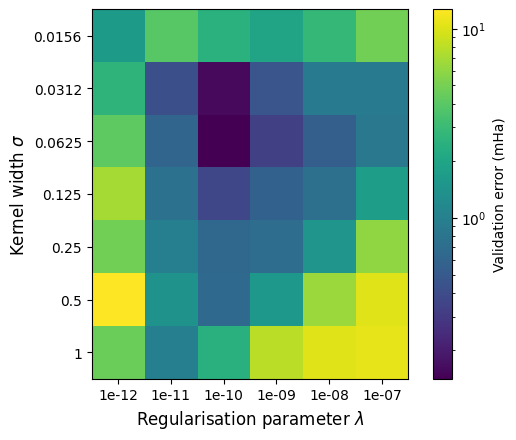

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.0001283917825722791 mHa
Outer fold 2/6


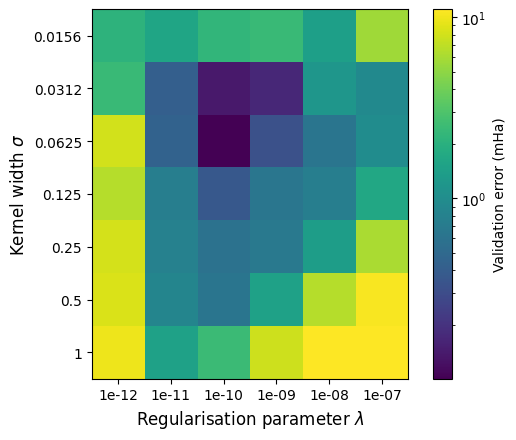

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00011482264379310732 mHa
Outer fold 3/6


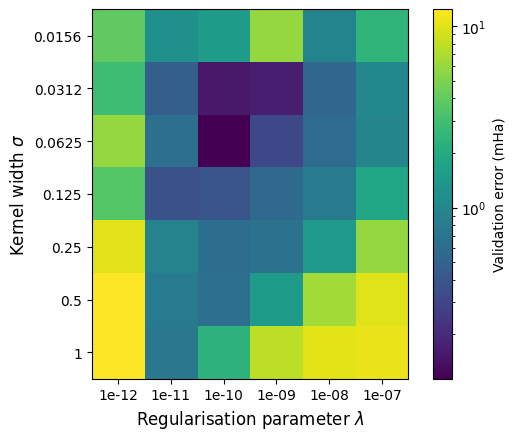

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00015576563635804065 mHa
Outer fold 4/6


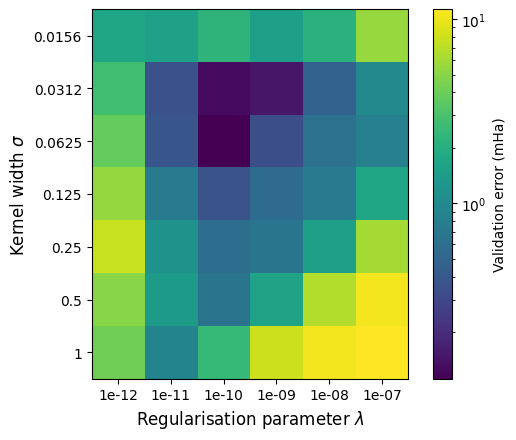

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.0001280213192058843 mHa
Outer fold 5/6


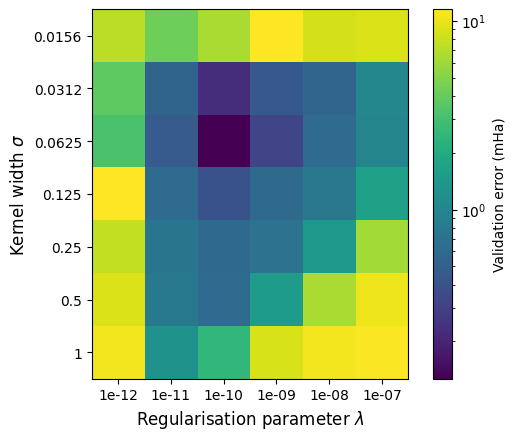

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00012202029334775768 mHa
Outer fold 6/6


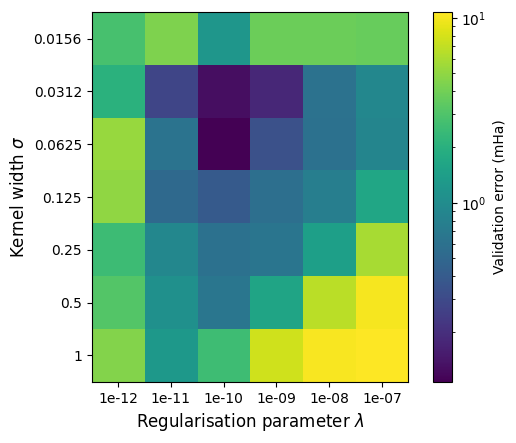

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 7.653486928060523e-05 mHa
Mean test error across folds: 0.00012092609075961238 pm 2.3554555988975103e-05
Functional: A1[d1]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


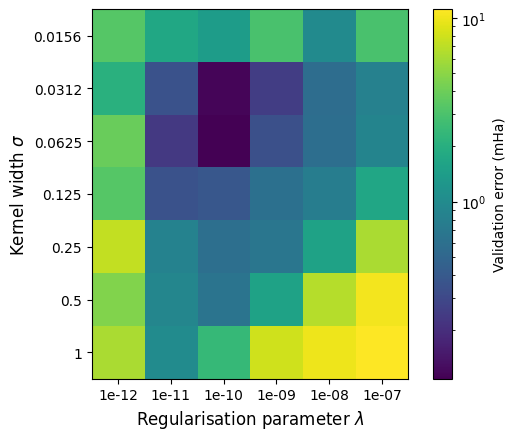

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 9.660267760444782e-05 mHa
Outer fold 2/6


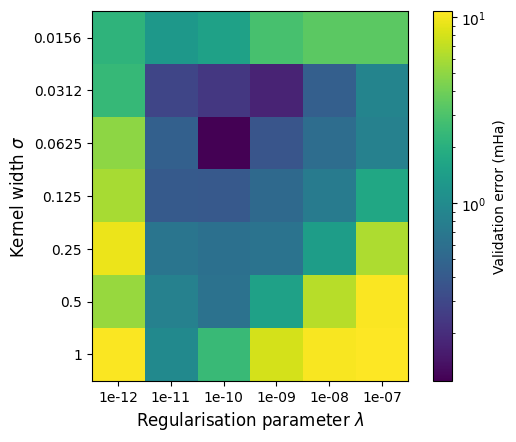

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00014074982072549057 mHa
Outer fold 3/6


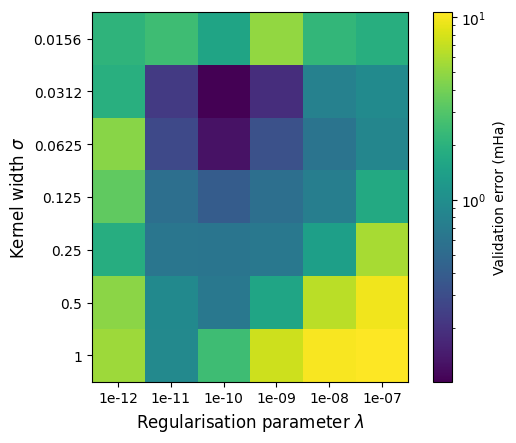

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.03125
Mean test error over 10 repeats: 6.744673846574105e-05 mHa
Outer fold 4/6


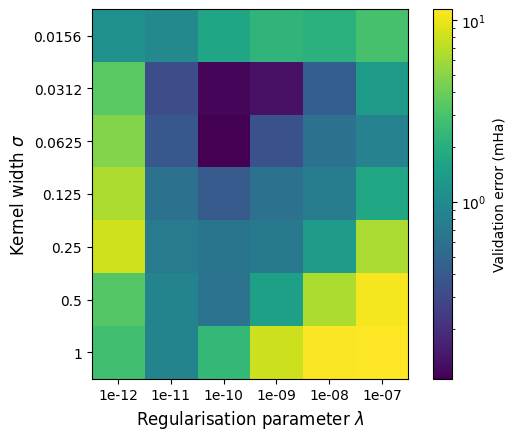

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00012291732281862015 mHa
Outer fold 5/6


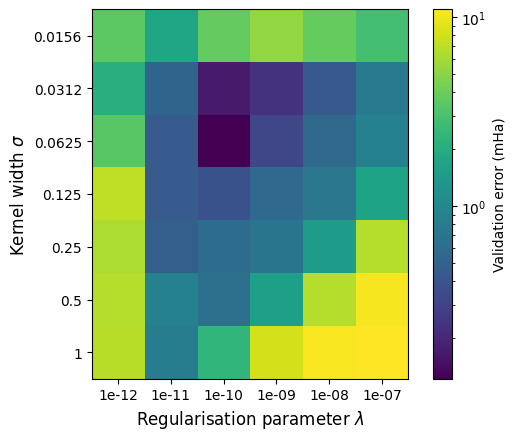

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00013741244099123583 mHa
Outer fold 6/6


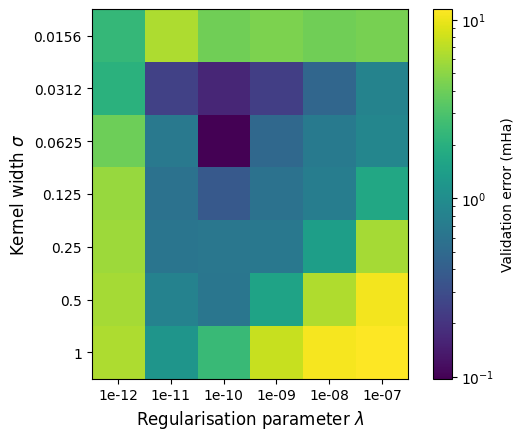

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 8.528140840236009e-05 mHa
Mean test error across folds: 0.00010840173483464925 pm 2.7232948795102105e-05
Functional: F1[d1]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


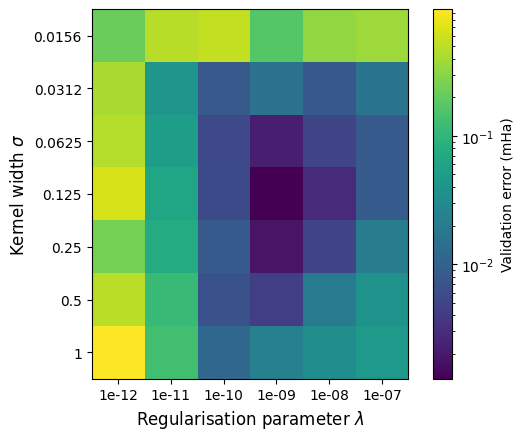

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.318723857268722e-06 mHa
Outer fold 2/6


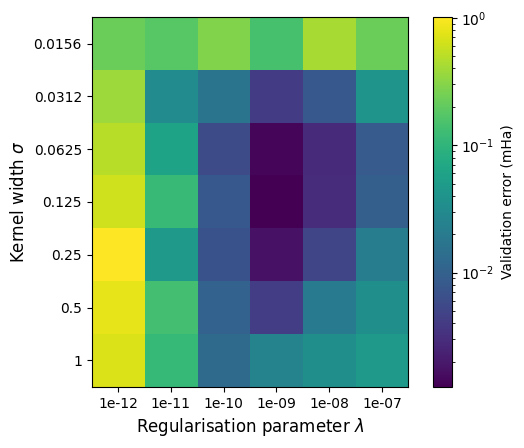

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.0868775896695953e-06 mHa
Outer fold 3/6


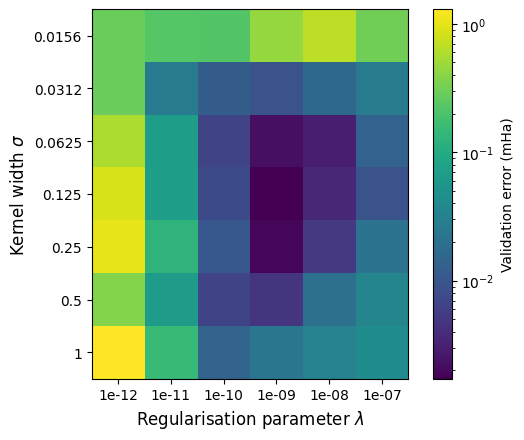

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.2284162973386083e-06 mHa
Outer fold 4/6


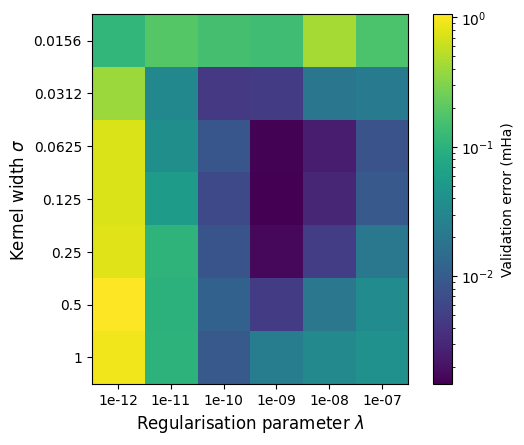

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 2.2102957695372773e-06 mHa
Outer fold 5/6


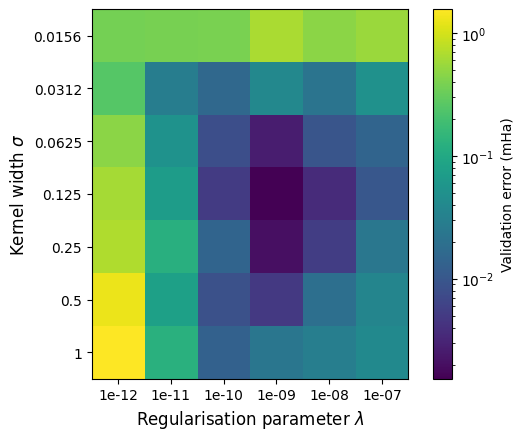

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.5336147140258362e-06 mHa
Outer fold 6/6


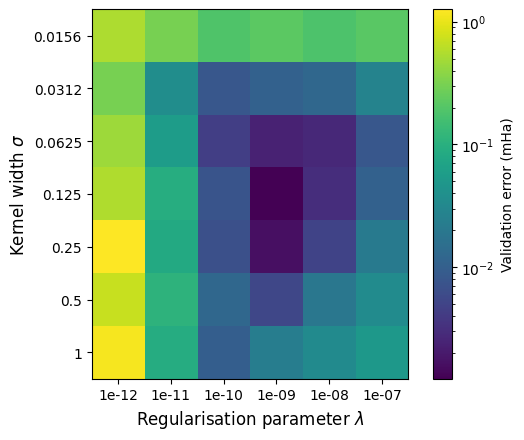

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 8.850596595573931e-07 mHa
Mean test error across folds: 1.377164647899572e-06 pm 4.2240568623134667e-07
Functional: G1[d1]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


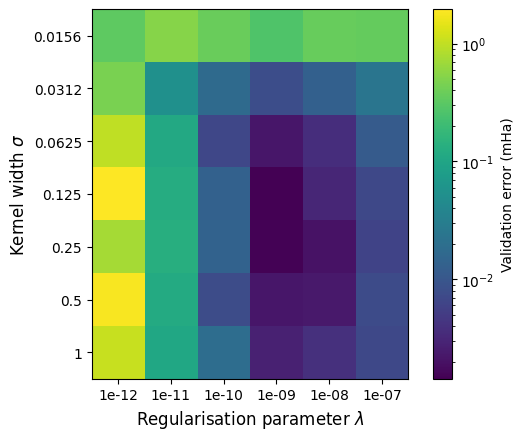

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.329796001958705e-06 mHa
Outer fold 2/6


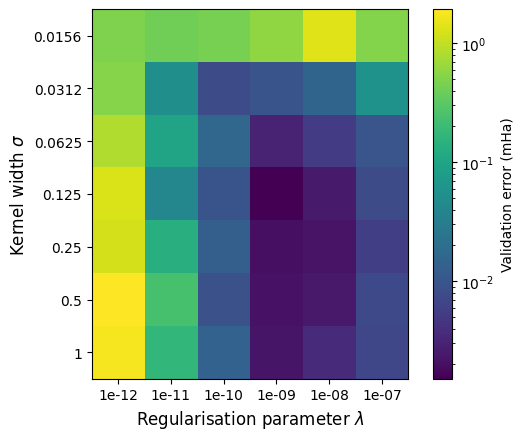

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.4889937248740992e-06 mHa
Outer fold 3/6


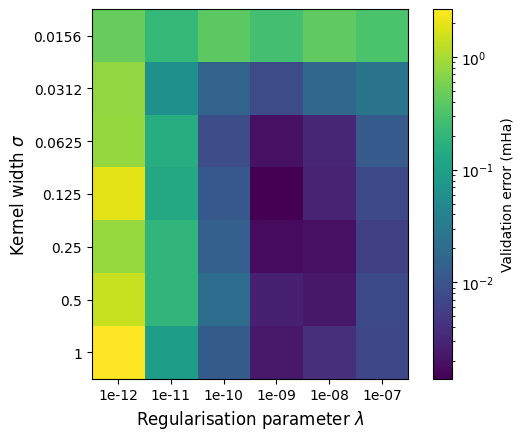

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.758005892342022e-06 mHa
Outer fold 4/6


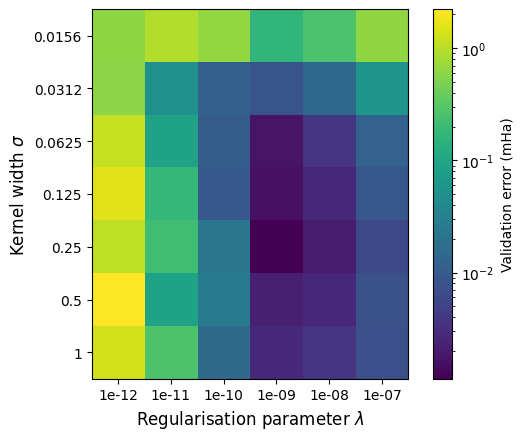

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 2.706820585918201e-06 mHa
Outer fold 5/6


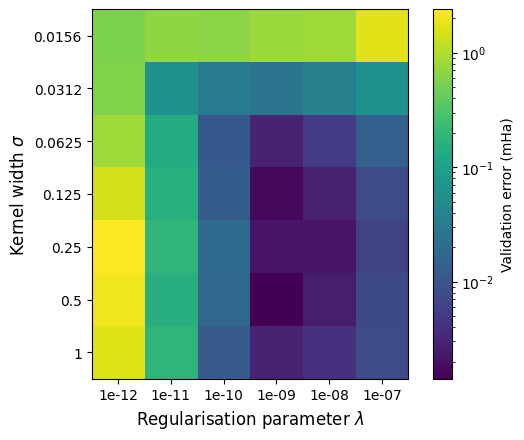

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 1.7242748173940115e-06 mHa
Outer fold 6/6


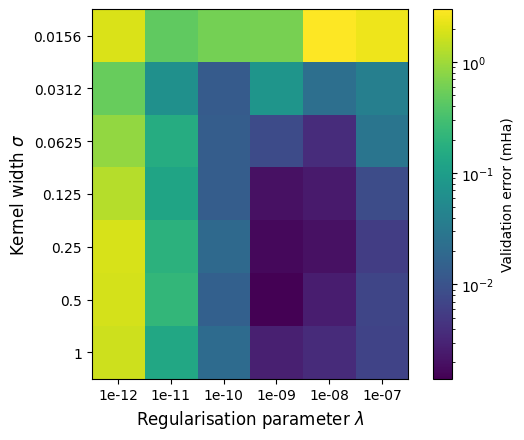

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 1.8871972991515073e-06 mHa
Mean test error across folds: 1.8158480536064243e-06 pm 4.385077898407432e-07
Functional: E1[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


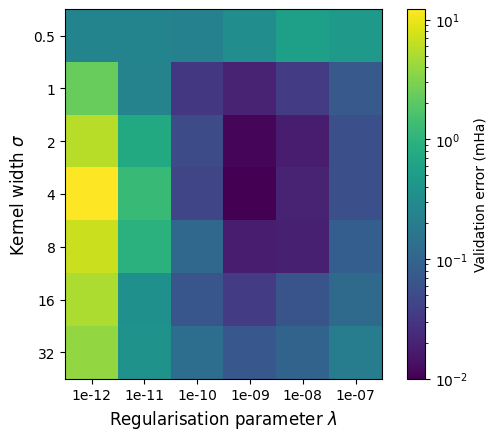

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.2441794329391223e-05 mHa
Outer fold 2/6


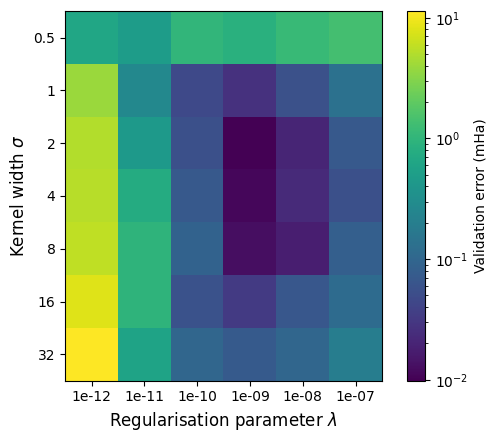

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 7.547284681108657e-06 mHa
Outer fold 3/6


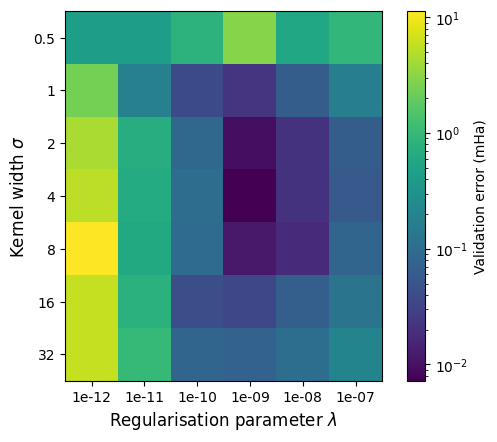

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 8.892299143159475e-06 mHa
Outer fold 4/6


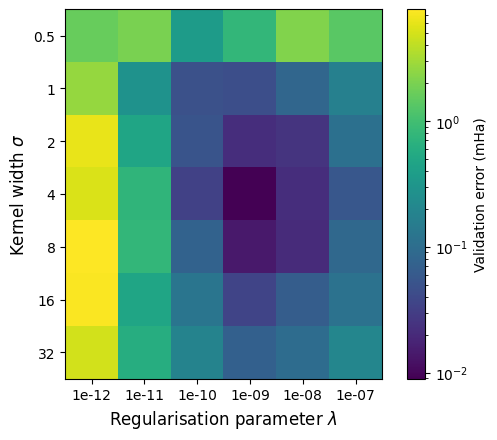

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 8.512764089174674e-06 mHa
Outer fold 5/6


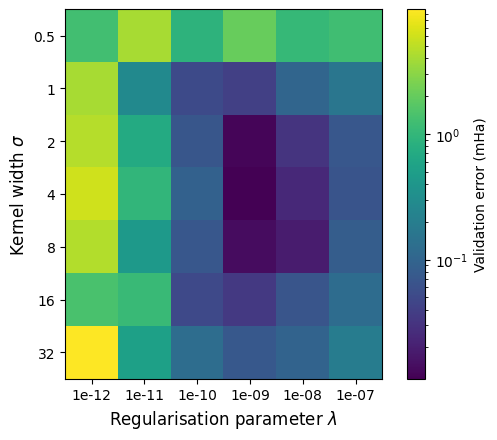

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.23003610881837e-05 mHa
Outer fold 6/6


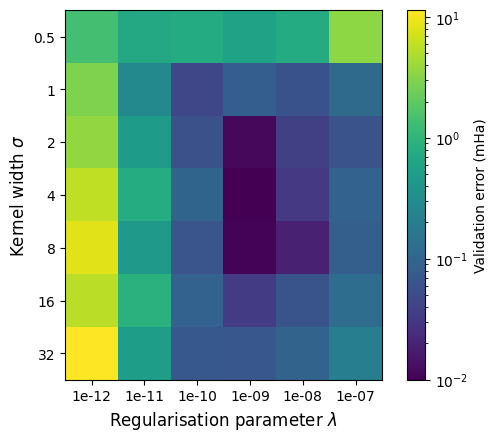

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.0892060552151563e-05 mHa
Mean test error across folds: 1.0097760647194882e-05 pm 1.8906407258369647e-06
Functional: A1[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


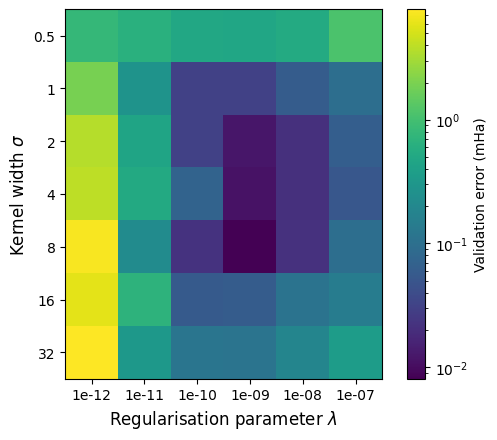

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 1.179204522285815e-05 mHa
Outer fold 2/6


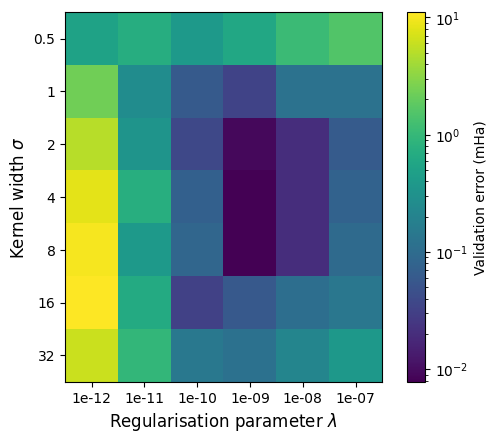

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 8.852538394780545e-06 mHa
Outer fold 3/6


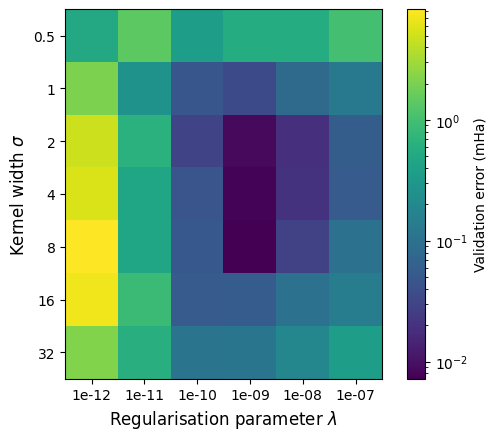

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 6.752872134082228e-06 mHa
Outer fold 4/6


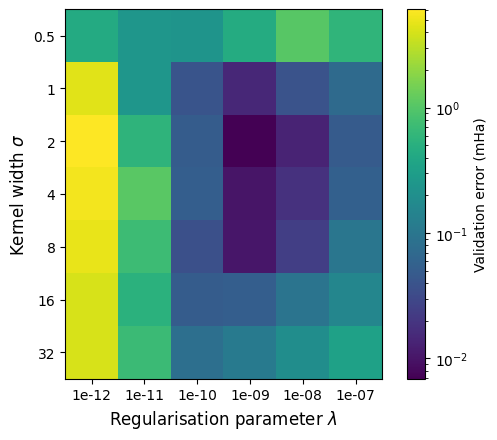

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.9318860560146865e-05 mHa
Outer fold 5/6


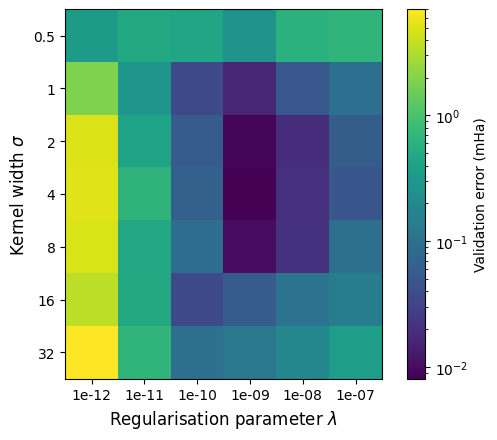

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 6.953991667968395e-06 mHa
Outer fold 6/6


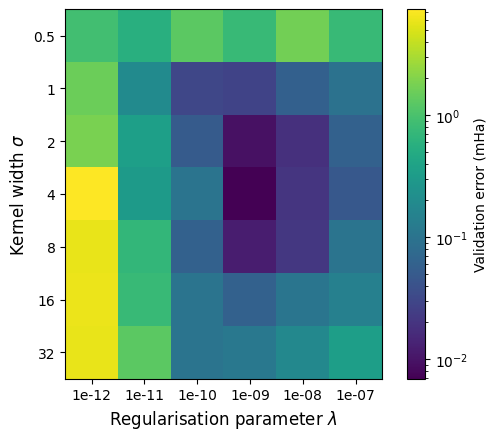

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 9.537866979062818e-06 mHa
Mean test error across folds: 1.0534695826483168e-05 pm 4.2756954923535996e-06
Functional: F1[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


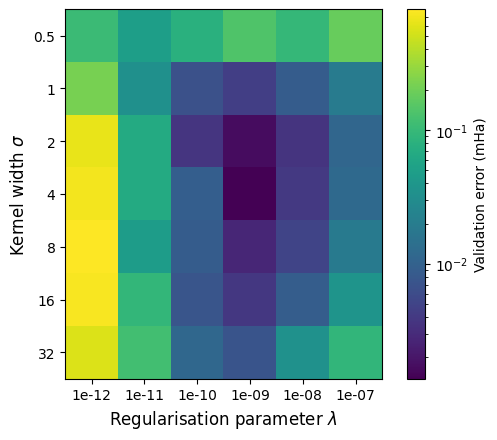

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.5326268170505013e-06 mHa
Outer fold 2/6


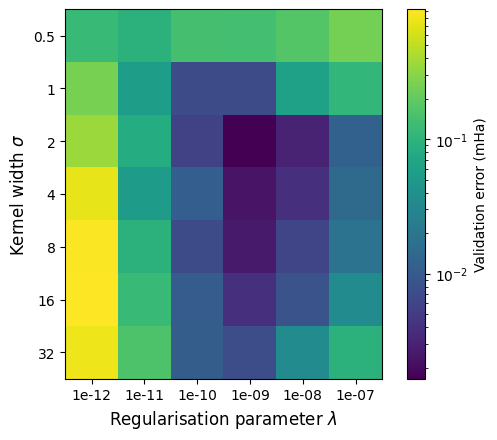

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 2.9851746462083997e-06 mHa
Outer fold 3/6


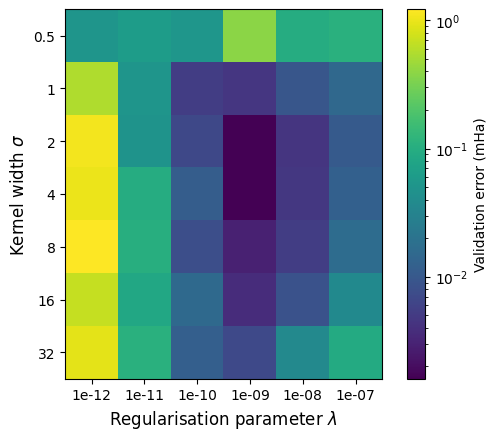

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.097651630314426e-06 mHa
Outer fold 4/6


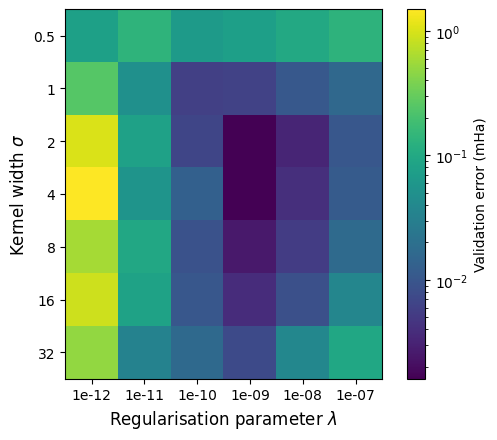

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.1983318888001786e-06 mHa
Outer fold 5/6


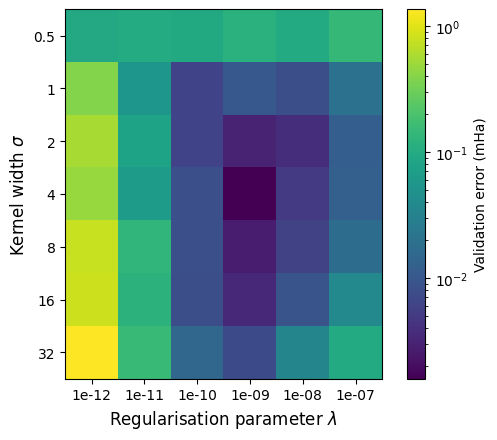

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.230654484607463e-06 mHa
Outer fold 6/6


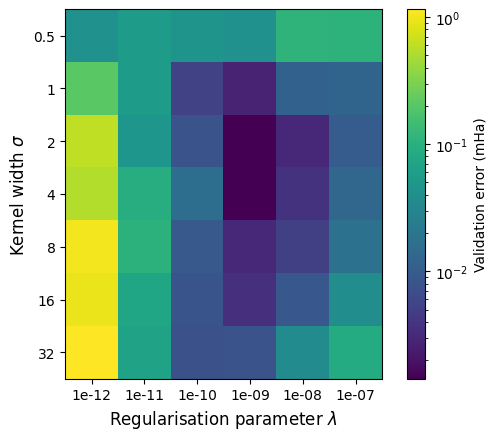

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 2.5535107272434134e-06 mHa
Mean test error across folds: 1.7663250323707305e-06 pm 7.321832444488643e-07
Functional: G1[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


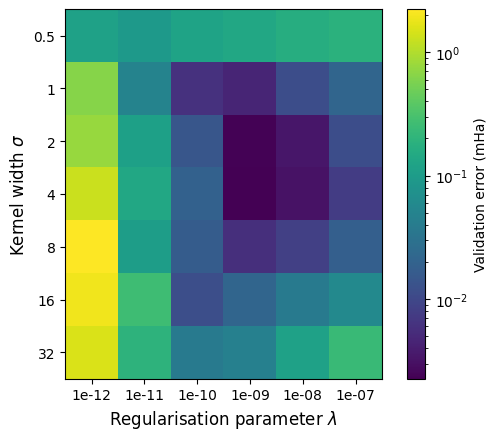

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.5201877225627196e-06 mHa
Outer fold 2/6


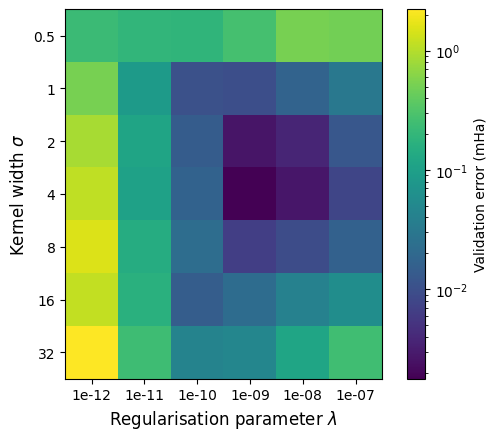

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.200551198638934e-06 mHa
Outer fold 3/6


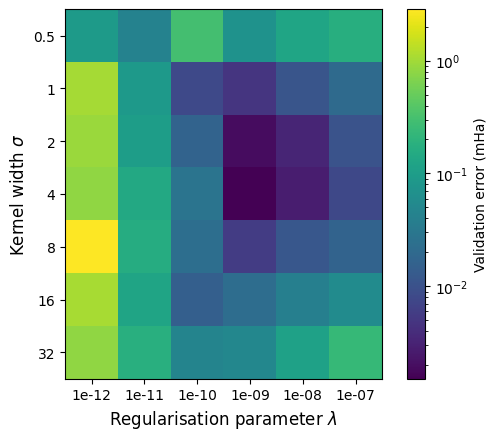

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.1263596955867216e-06 mHa
Outer fold 4/6


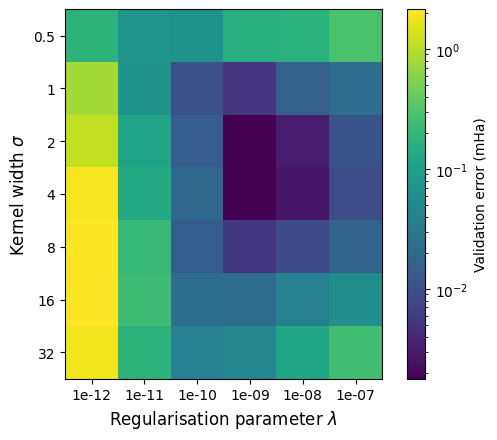

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.2116769875373618e-06 mHa
Outer fold 5/6


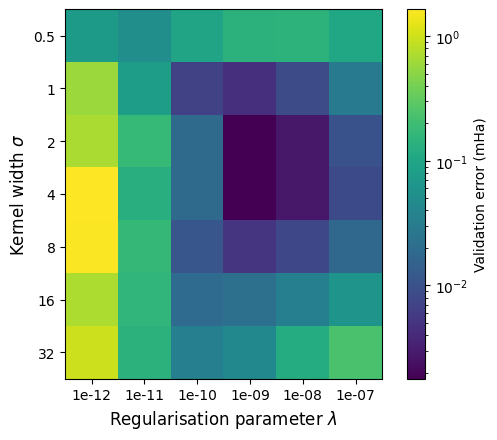

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 7.394361868776991e-06 mHa
Outer fold 6/6


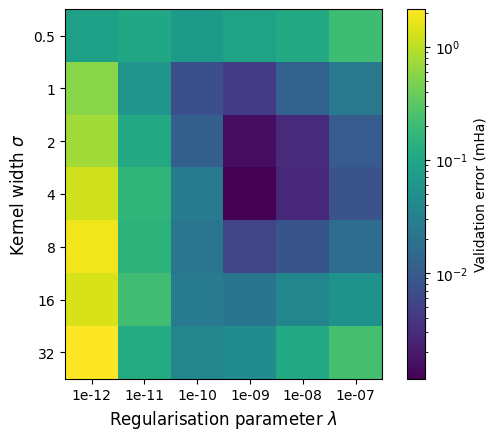

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.0594582320843103e-06 mHa
Mean test error across folds: 2.75209928419784e-06 pm 2.1062057434493574e-06
Functional: E2[d2]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


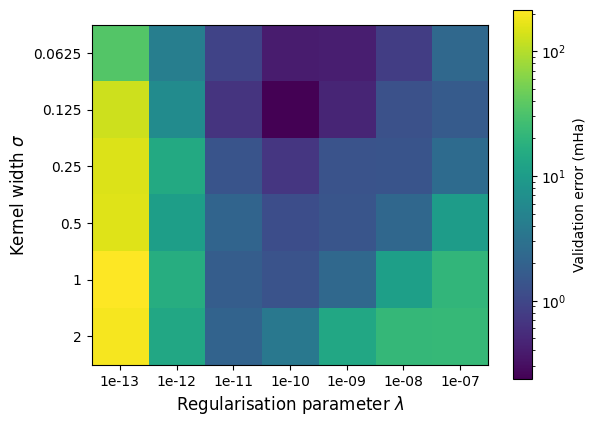

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00017117566465496556 mHa
Outer fold 2/6


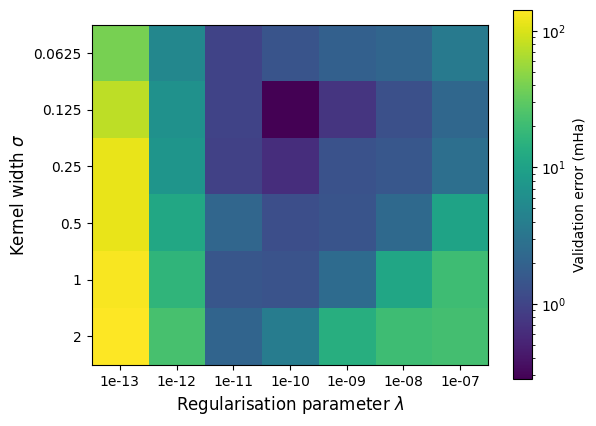

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.0003961078210413953 mHa
Outer fold 3/6


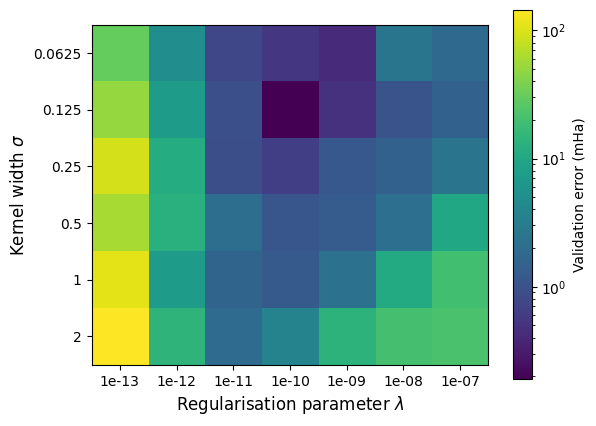

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.0002126095743395432 mHa
Outer fold 4/6


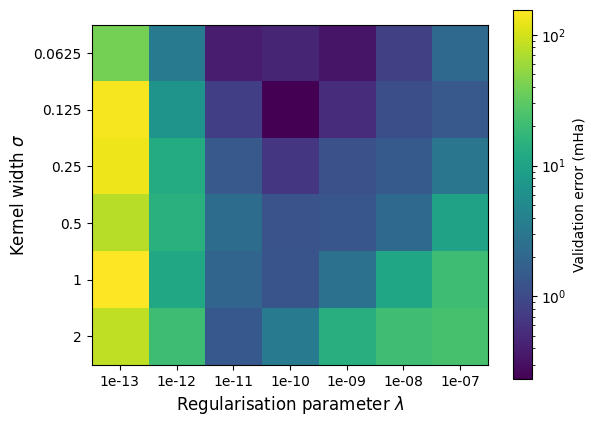

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00013275078248076166 mHa
Outer fold 5/6


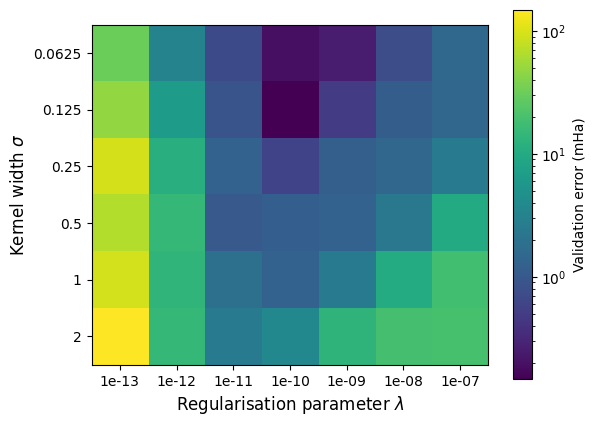

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00022682245733736118 mHa
Outer fold 6/6


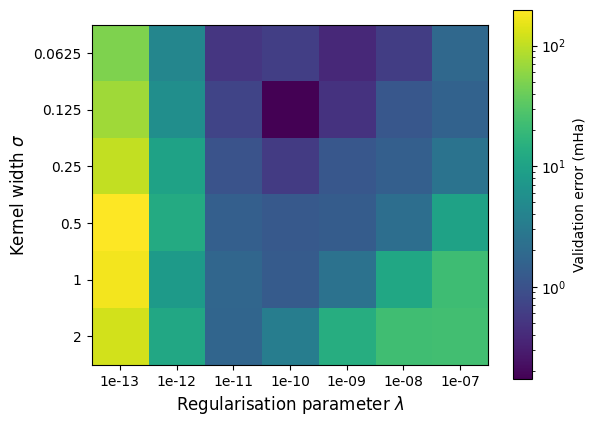

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00015906694676461885 mHa
Mean test error across folds: 0.00021642220776977425 pm 8.635913773330969e-05
Functional: I2[d2]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


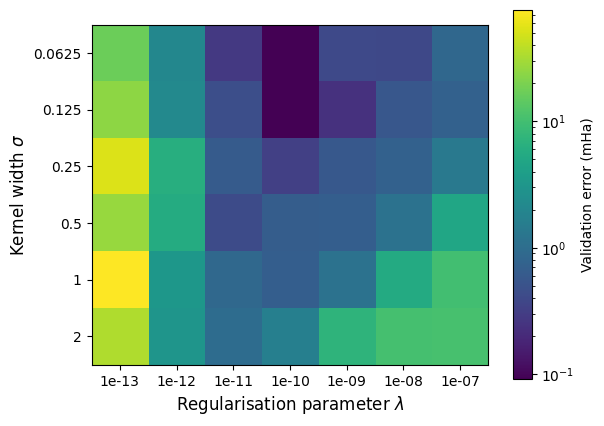

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 7.416566044414023e-05 mHa
Outer fold 2/6


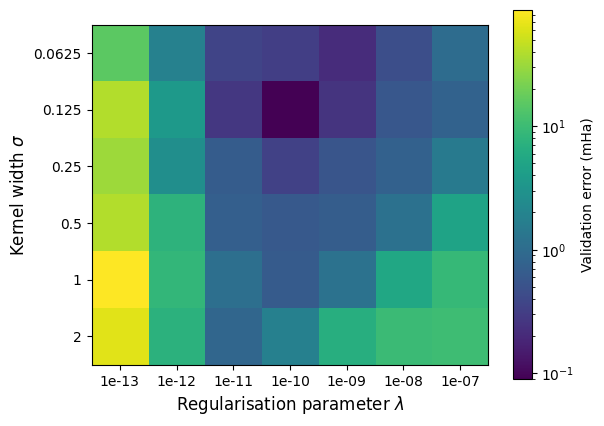

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 9.502500430315086e-05 mHa
Outer fold 3/6


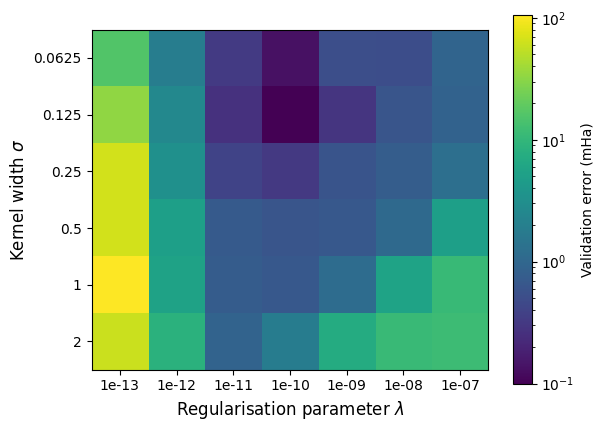

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 8.292486224982984e-05 mHa
Outer fold 4/6


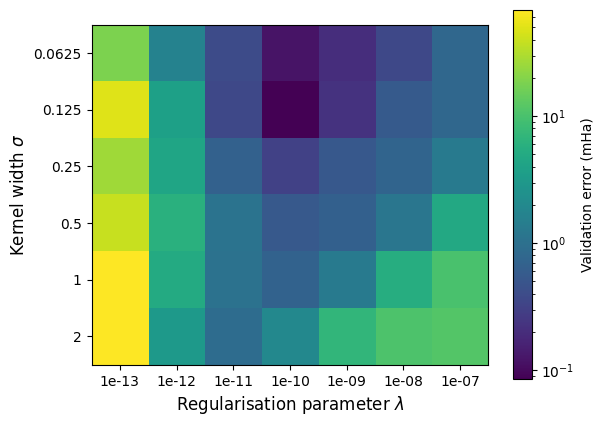

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 8.501925956564774e-05 mHa
Outer fold 5/6


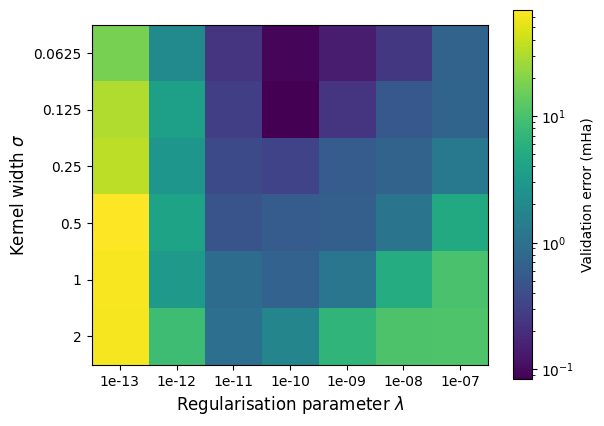

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00012789516794640504 mHa
Outer fold 6/6


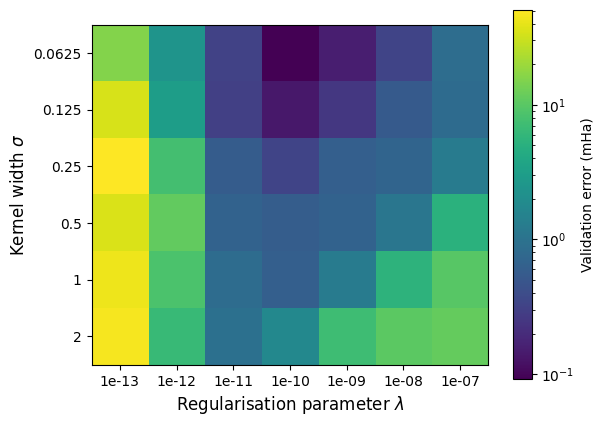

Best kernel width 0.0625 is the minimum kernel width. Increase search space.
Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.0625
Mean test error over 10 repeats: 8.182595784808806e-05 mHa
Mean test error across folds: 9.114265205954362e-05 pm 1.753979819005731e-05
Functional: A2[d2]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


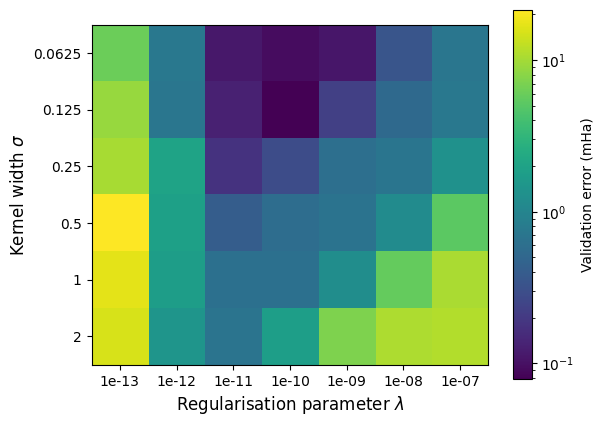

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 7.310563764795959e-05 mHa
Outer fold 2/6


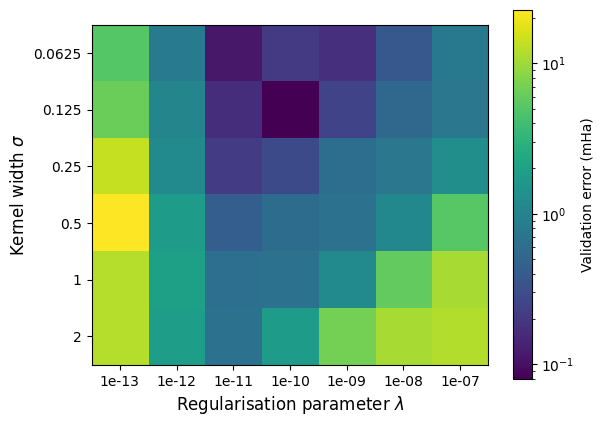

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 6.483695545741094e-05 mHa
Outer fold 3/6


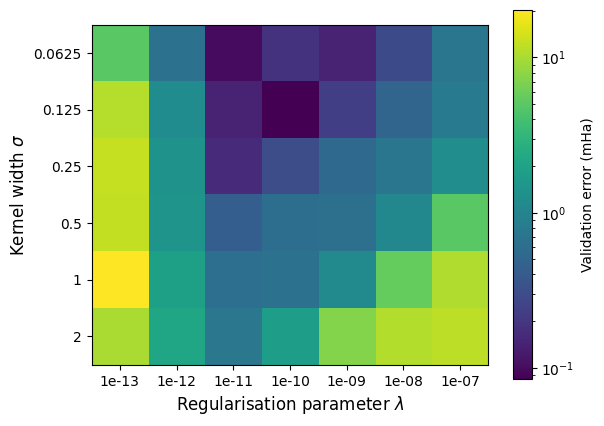

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00010877609666575989 mHa
Outer fold 4/6


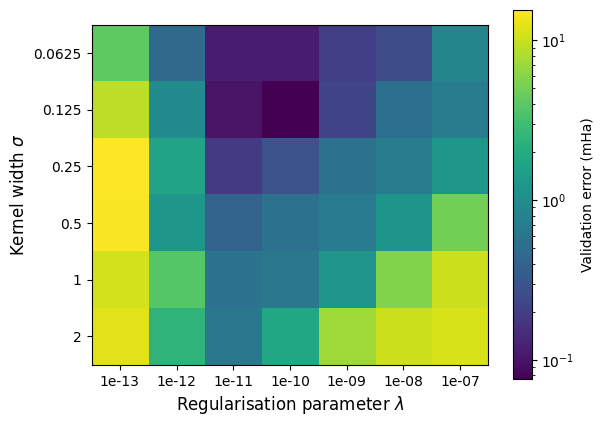

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 4.822067782709698e-05 mHa
Outer fold 5/6


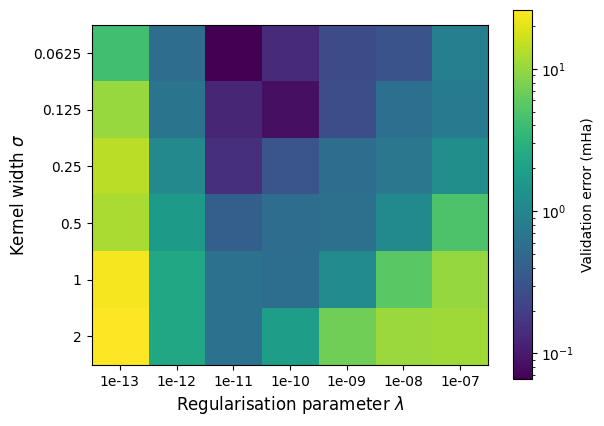

Best kernel width 0.0625 is the minimum kernel width. Increase search space.
Best hyperparameters: regularisation_parameter = 1e-11, kernel_width = 0.0625
Mean test error over 10 repeats: 0.00020993590131124974 mHa
Outer fold 6/6


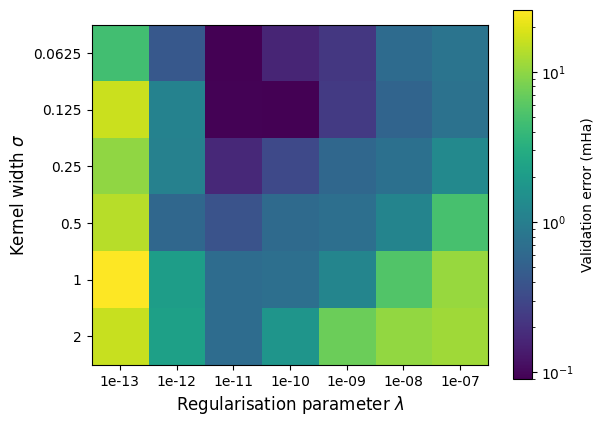

Best kernel width 0.0625 is the minimum kernel width. Increase search space.
Best hyperparameters: regularisation_parameter = 1e-11, kernel_width = 0.0625
Mean test error over 10 repeats: 8.64825898379736e-05 mHa
Mean test error across folds: 9.855964312457514e-05 pm 5.318840649401082e-05
Functional: F2[d2]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


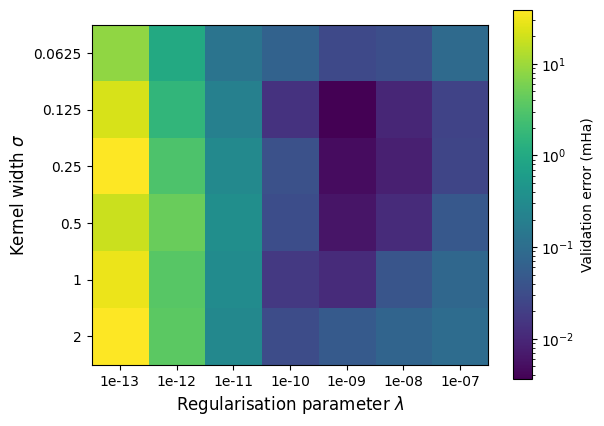

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 8.961355101614703e-06 mHa
Outer fold 2/6


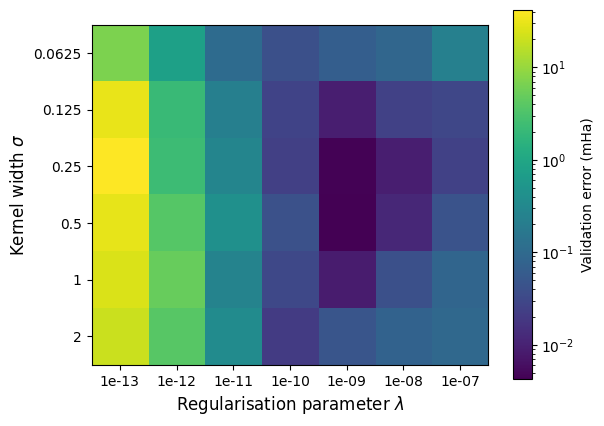

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 4.480033286709725e-06 mHa
Outer fold 3/6


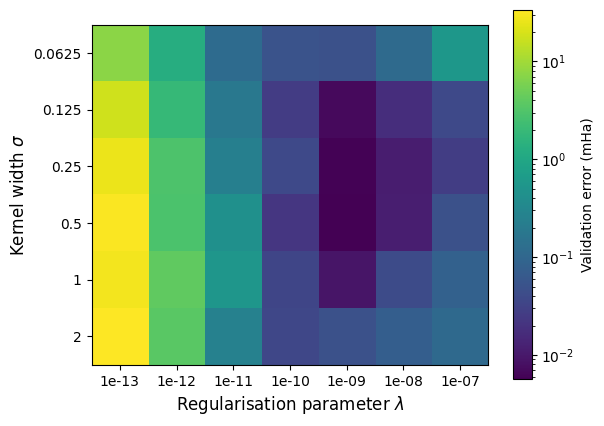

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 3.889299269495735e-06 mHa
Outer fold 4/6


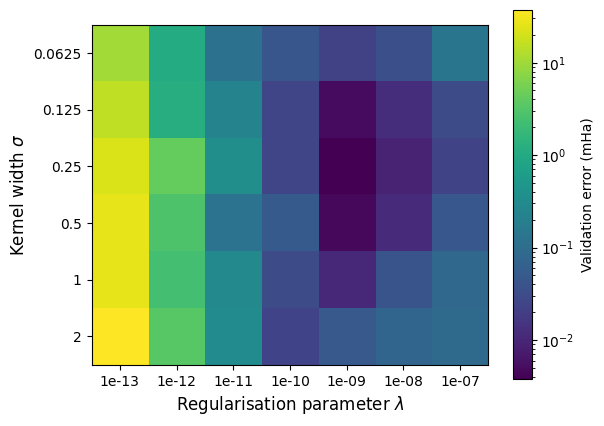

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 3.3355946117863413e-06 mHa
Outer fold 5/6


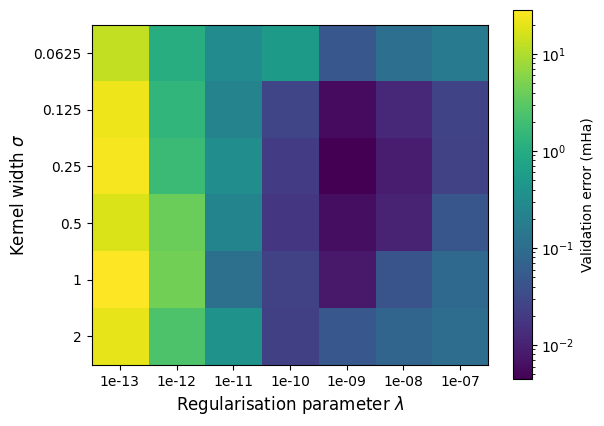

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 4.126183969040594e-06 mHa
Outer fold 6/6


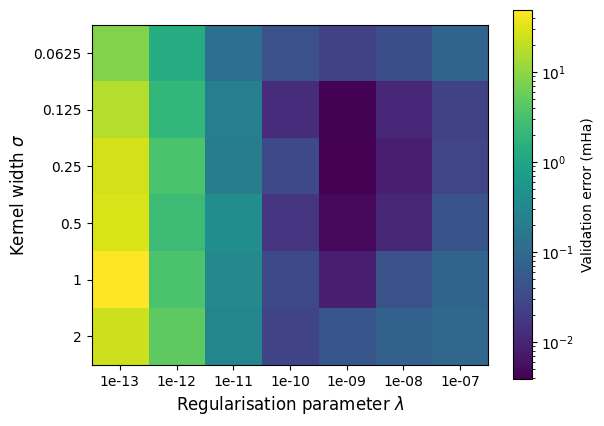

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 3.913349941497834e-06 mHa
Mean test error across folds: 4.784302696690822e-06 pm 1.8987632763964808e-06
Functional: G2[d2]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


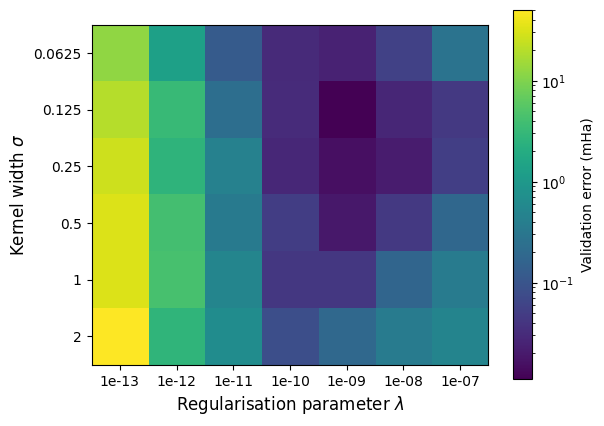

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 9.370611719465108e-06 mHa
Outer fold 2/6


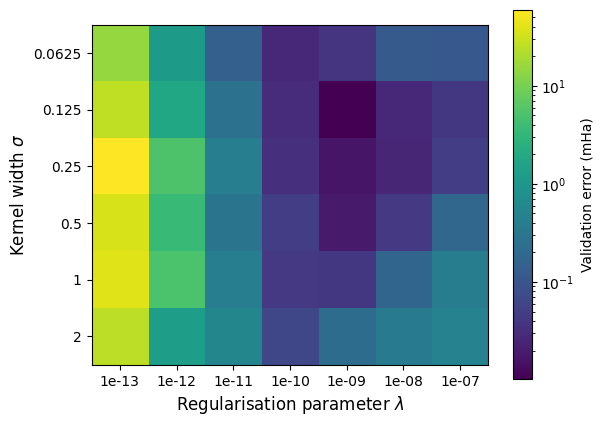

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 2.3592373732280363e-05 mHa
Outer fold 3/6


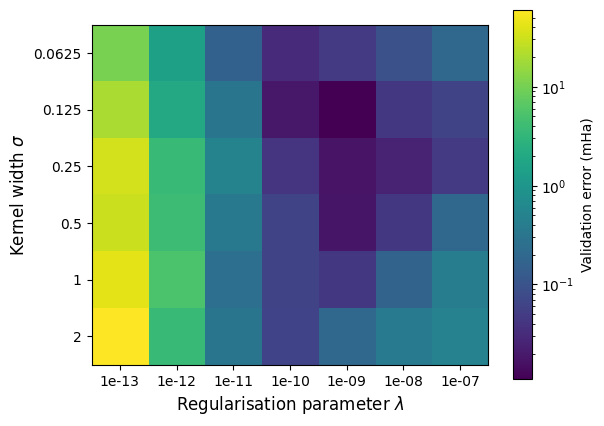

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 7.202398429632477e-06 mHa
Outer fold 4/6


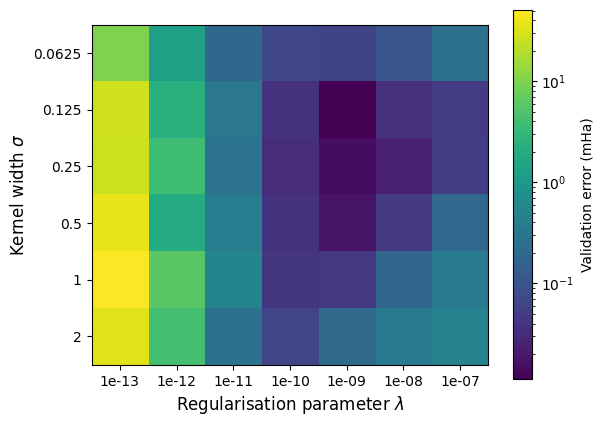

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.1260298925763746e-05 mHa
Outer fold 5/6


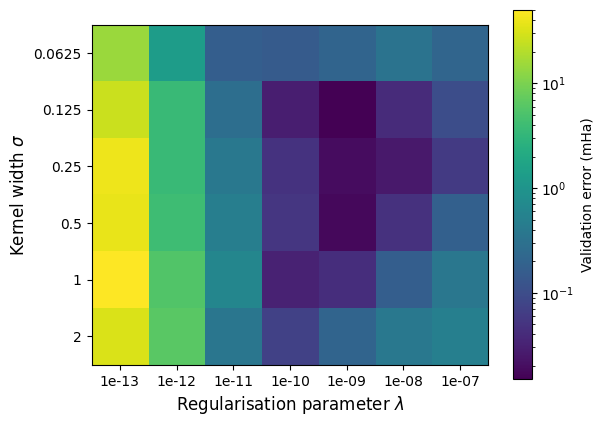

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 1.4056445598538878e-05 mHa
Outer fold 6/6


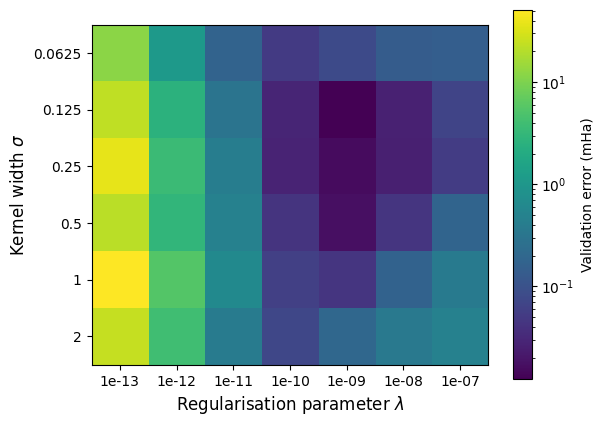

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.125
Mean test error over 10 repeats: 6.121380748787726e-06 mHa
Mean test error across folds: 1.1933918192411383e-05 pm 5.825545495982981e-06
Functional: E2[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


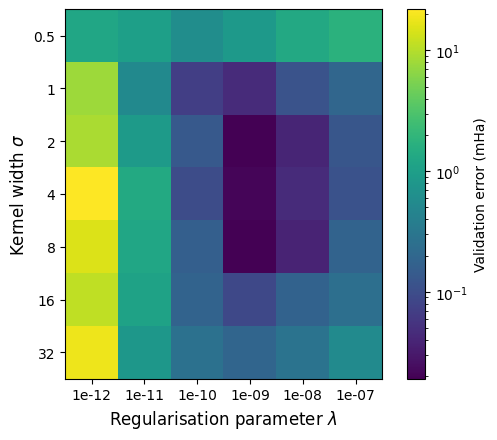

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 1.5265799173413973e-05 mHa
Outer fold 2/6


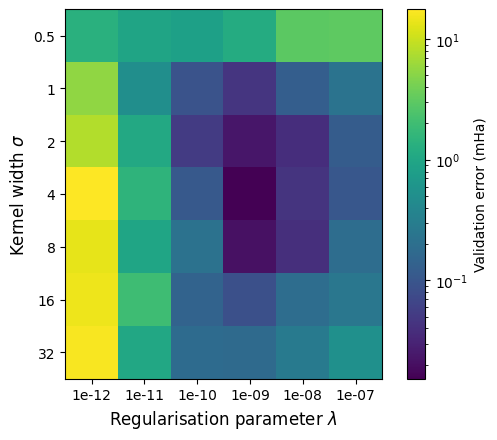

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.7504022970982193e-05 mHa
Outer fold 3/6


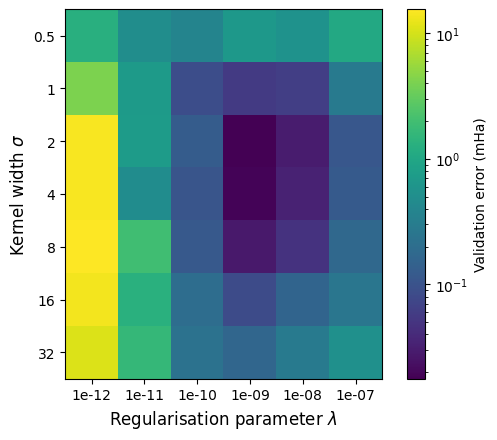

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 0.00015002487773982203 mHa
Outer fold 4/6


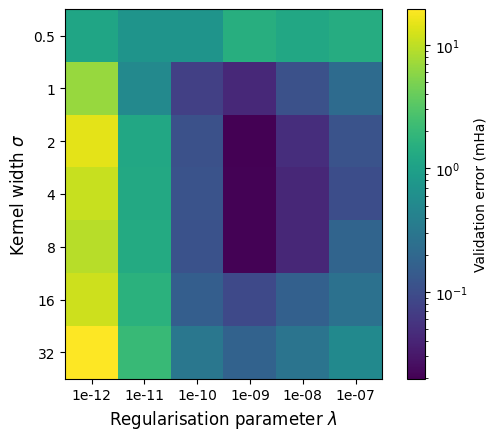

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.4507152891278055e-05 mHa
Outer fold 5/6


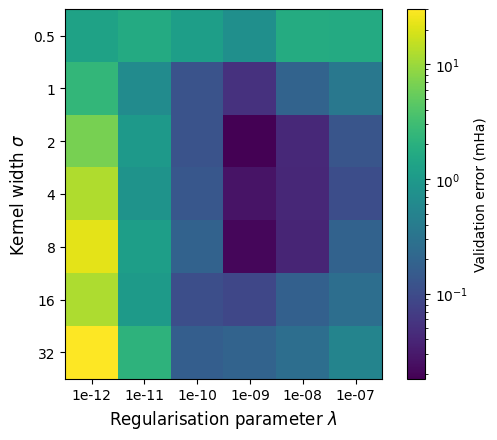

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.4638449290971245e-05 mHa
Outer fold 6/6


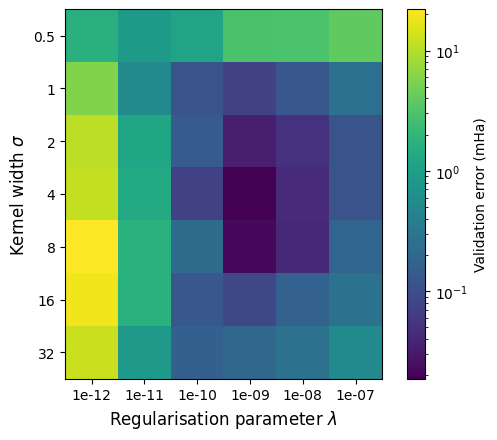

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.0126036703057203e-05 mHa
Mean test error across folds: 3.867772312825412e-05 pm 4.983456100460968e-05
Functional: I2[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


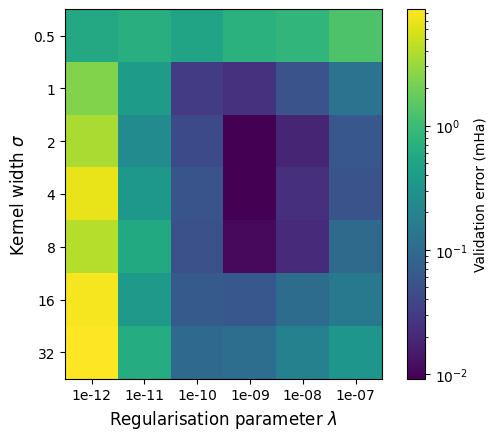

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 9.81311378337457e-06 mHa
Outer fold 2/6


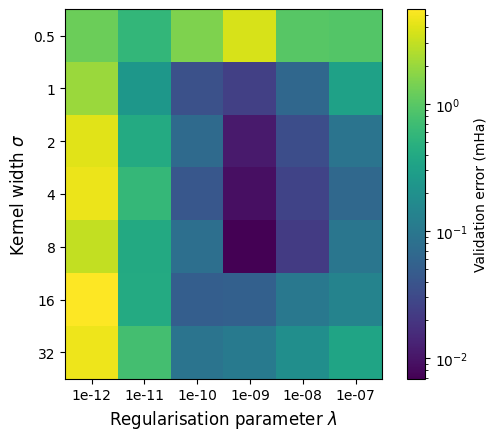

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 7.647456491377547e-06 mHa
Outer fold 3/6


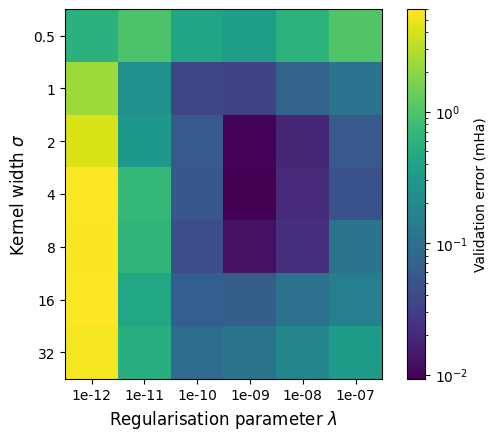

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 8.904032380259904e-06 mHa
Outer fold 4/6


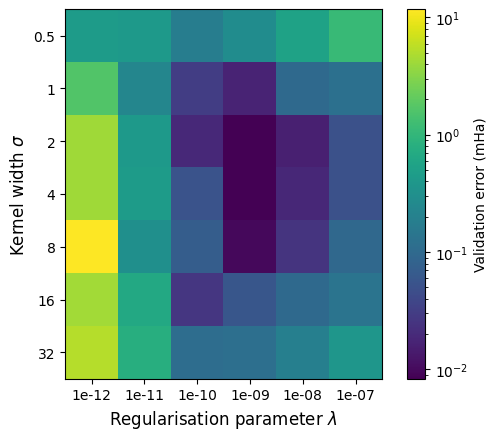

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.8955891660525174e-05 mHa
Outer fold 5/6


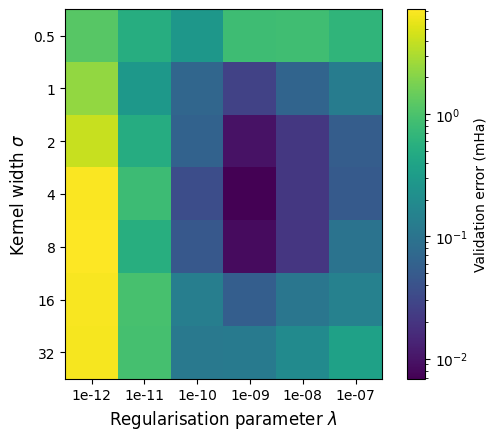

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 8.508617728830714e-06 mHa
Outer fold 6/6


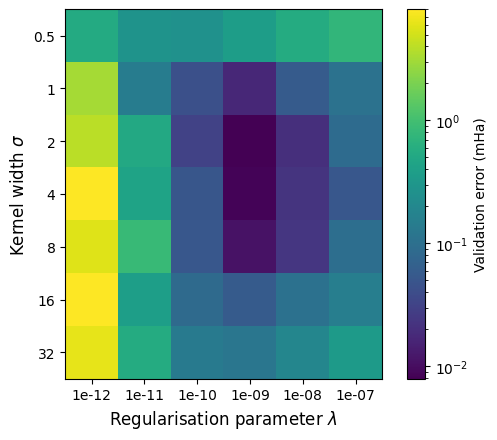

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 7.703394192681845e-06 mHa
Mean test error across folds: 1.0255417706174961e-05 pm 3.9599183064323605e-06
Functional: A2[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


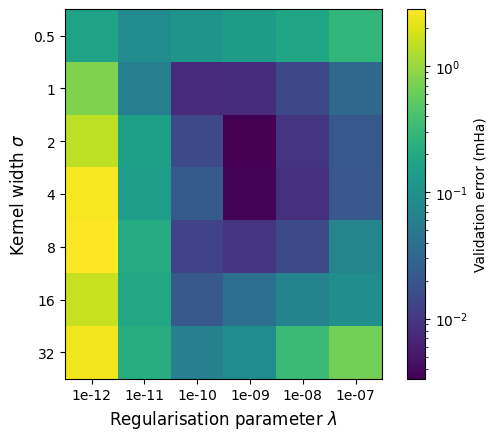

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 2.4384940943515216e-06 mHa
Outer fold 2/6


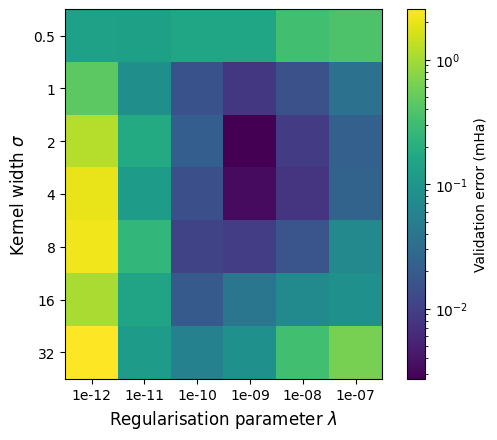

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 8.587820063225376e-06 mHa
Outer fold 3/6


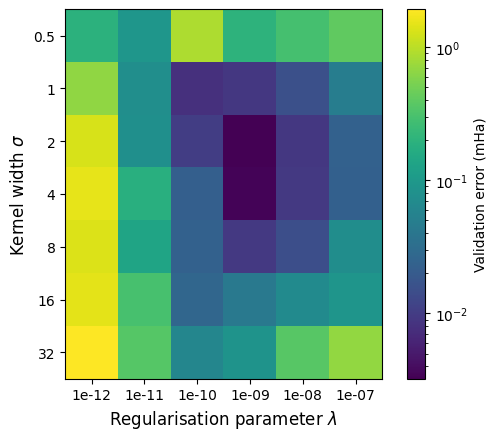

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 3.225865569733699e-06 mHa
Outer fold 4/6


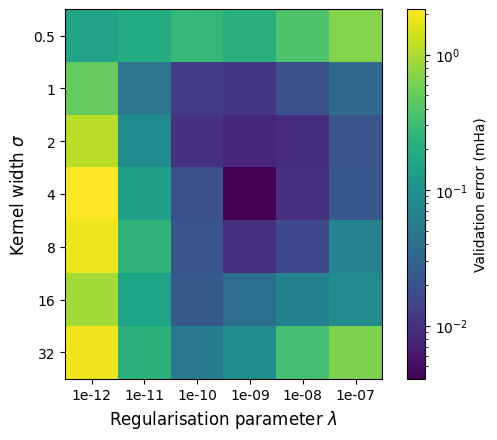

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 3.4740704896026507e-06 mHa
Outer fold 5/6


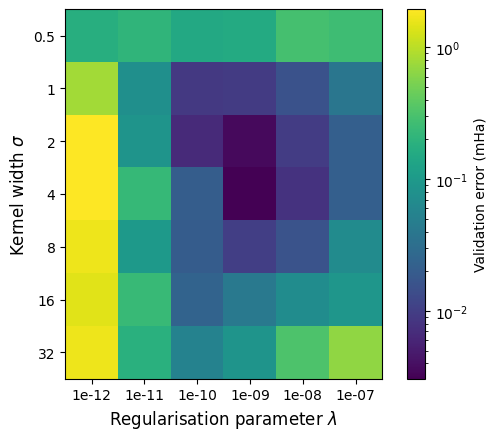

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.4954174234611176e-06 mHa
Outer fold 6/6


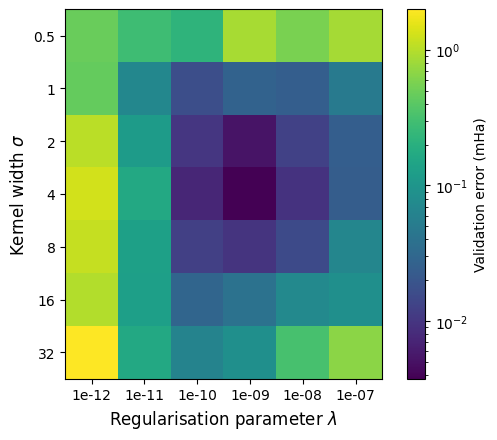

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.5224285256160905e-06 mHa
Mean test error across folds: 3.790682694331743e-06 pm 2.1812222635013227e-06
Functional: F2[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


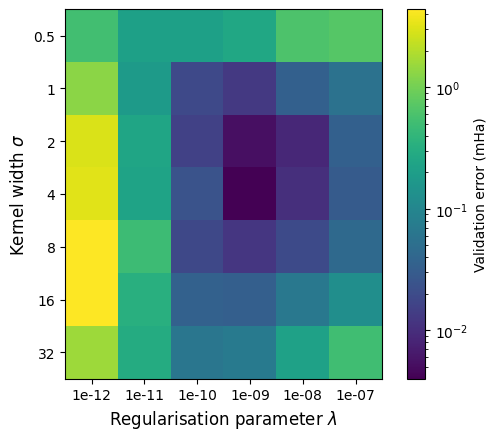

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 4.136340952450487e-06 mHa
Outer fold 2/6


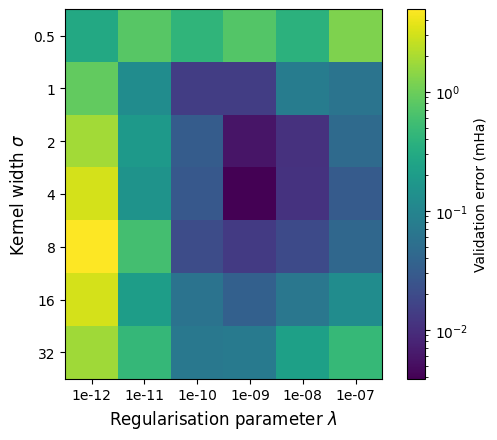

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 4.262578355166783e-06 mHa
Outer fold 3/6


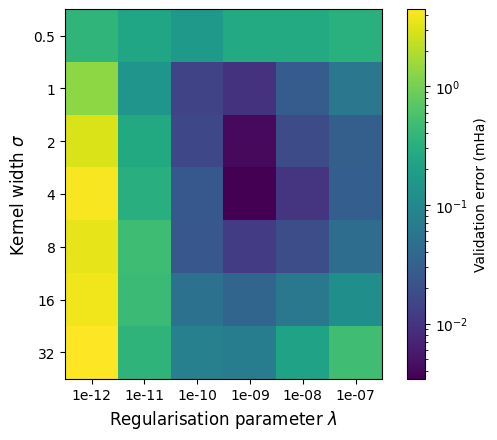

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 4.394223450524907e-06 mHa
Outer fold 4/6


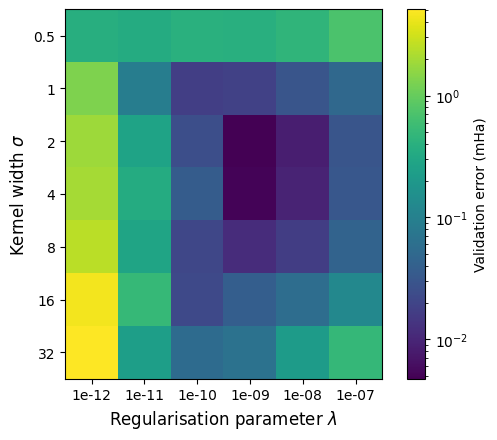

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 4.047125112046264e-06 mHa
Outer fold 5/6


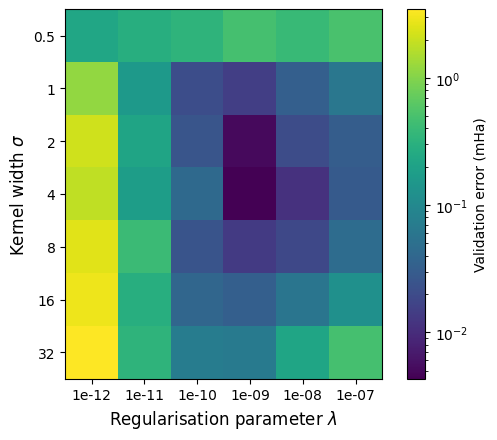

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 4.314205188604703e-06 mHa
Outer fold 6/6


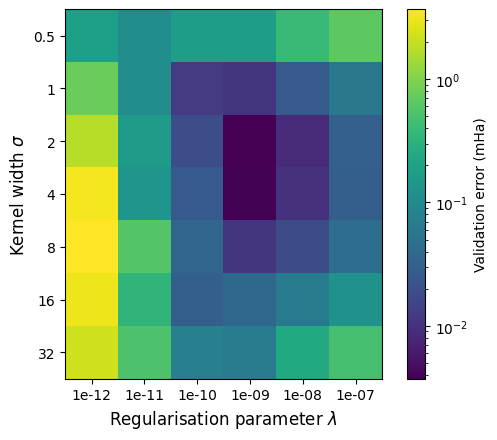

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.4894844406206551e-05 mHa
Mean test error across folds: 6.008219577499949e-06 pm 3.975840654509814e-06
Functional: G2[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


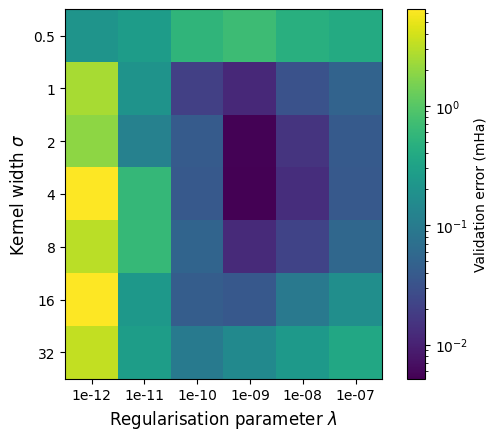

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 7.90939730720419e-06 mHa
Outer fold 2/6


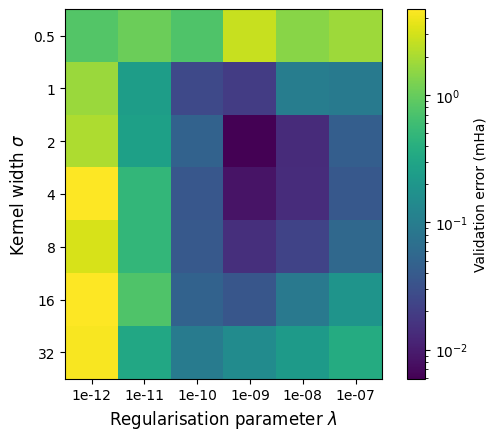

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 9.806141079423311e-06 mHa
Outer fold 3/6


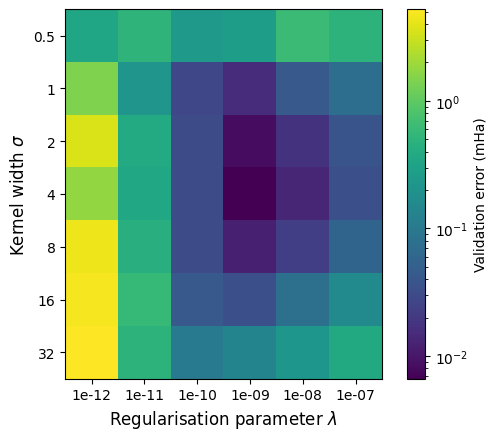

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 6.6948533407088884e-06 mHa
Outer fold 4/6


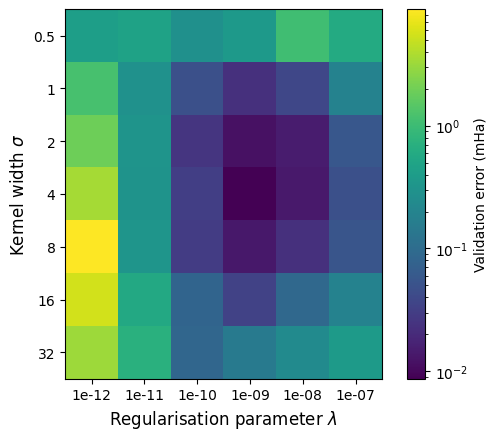

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 5.99295337222842e-06 mHa
Outer fold 5/6


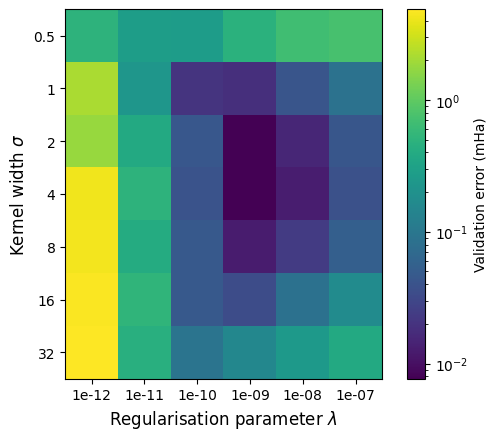

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 3.395220184465586e-06 mHa
Outer fold 6/6


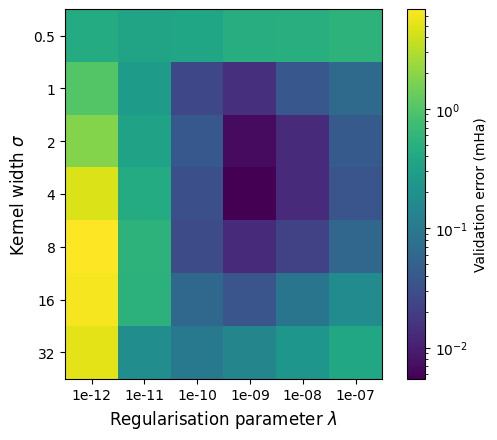

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 5.527896089866739e-06 mHa
Mean test error across folds: 6.554410228982856e-06 pm 1.9907667949253116e-06
Functional: E3[d3]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


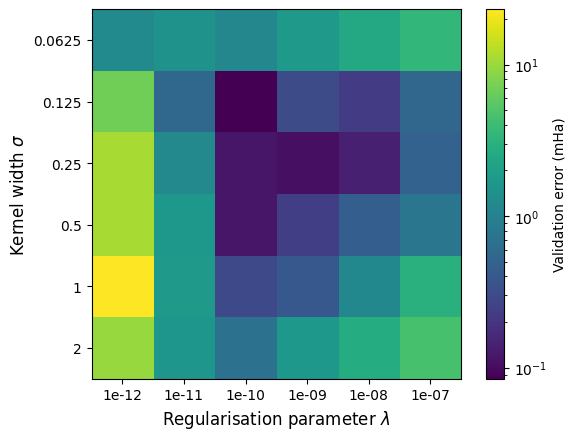

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 7.025648684257183e-05 mHa
Outer fold 2/6


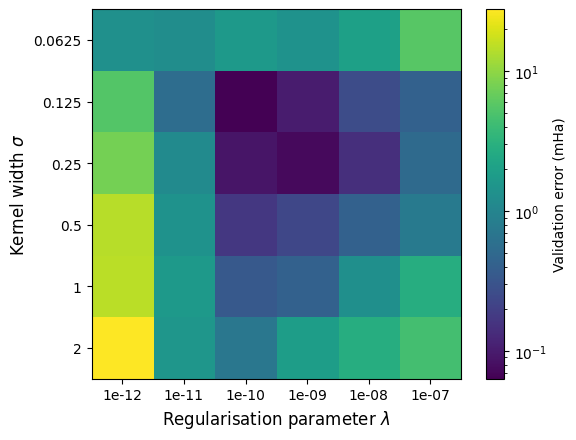

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00014990883842567194 mHa
Outer fold 3/6


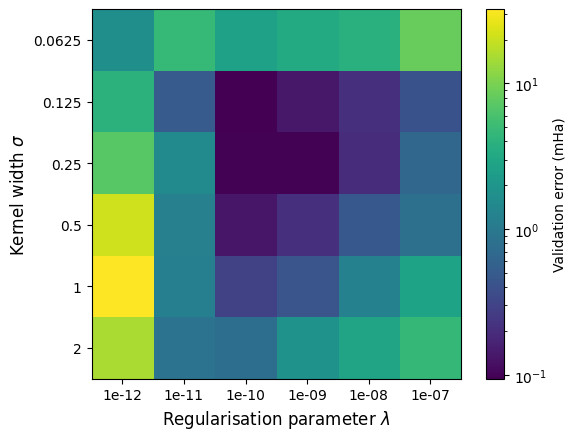

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 0.00010245300221981189 mHa
Outer fold 4/6


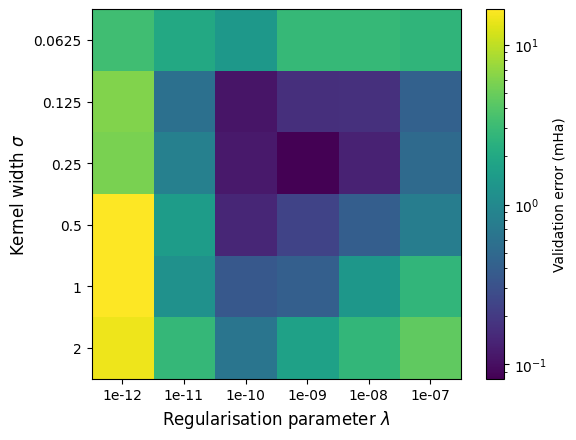

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 7.755131467040618e-05 mHa
Outer fold 5/6


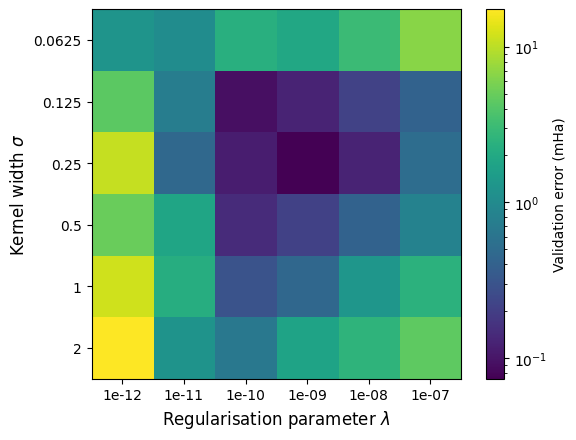

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 0.0001225774445414644 mHa
Outer fold 6/6


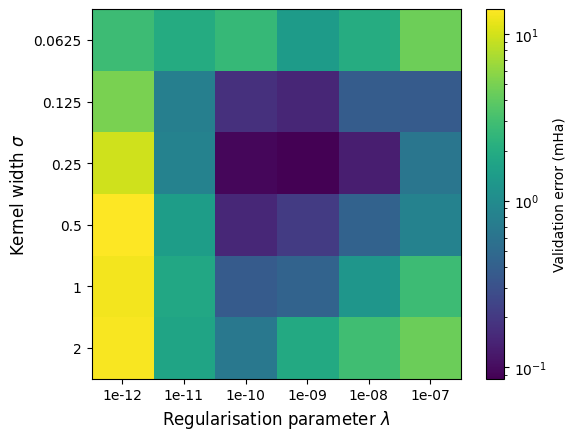

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 6.444933027667243e-05 mHa
Mean test error across folds: 9.786606949609978e-05 pm 3.0637119599952105e-05
Functional: I3[d3]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


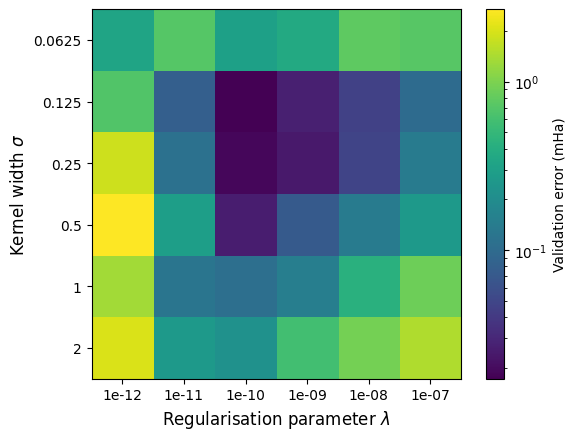

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 1.3060850768450056e-05 mHa
Outer fold 2/6


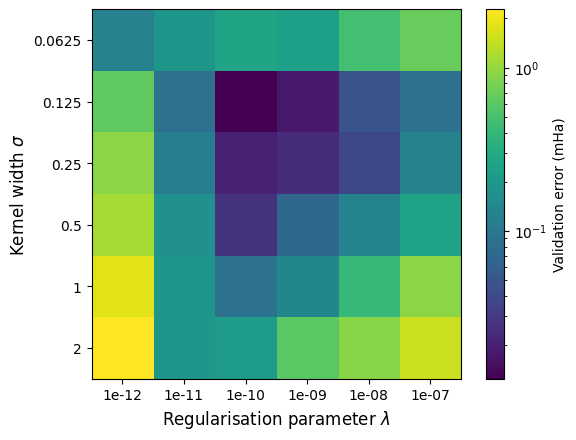

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 1.0454283612200872e-05 mHa
Outer fold 3/6


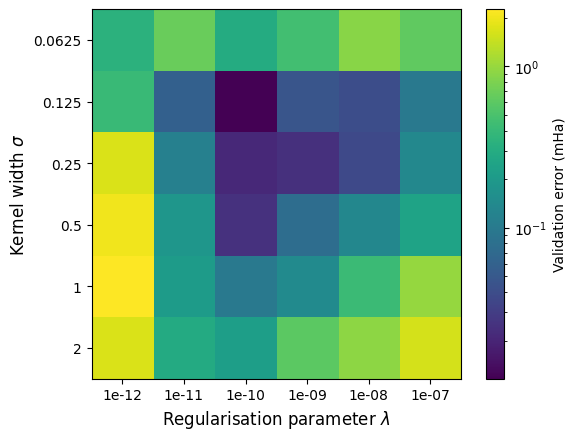

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 2.2309167940822344e-05 mHa
Outer fold 4/6


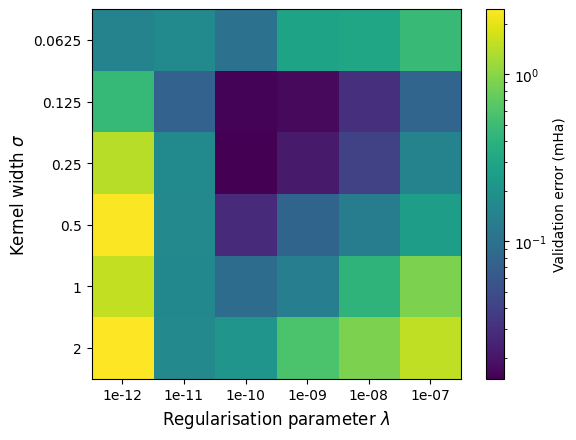

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.25
Mean test error over 10 repeats: 1.6333806542282818e-05 mHa
Outer fold 5/6


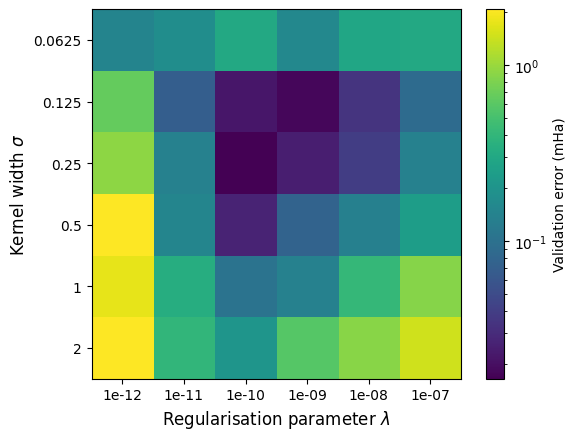

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.25
Mean test error over 10 repeats: 8.86135007969191e-06 mHa
Outer fold 6/6


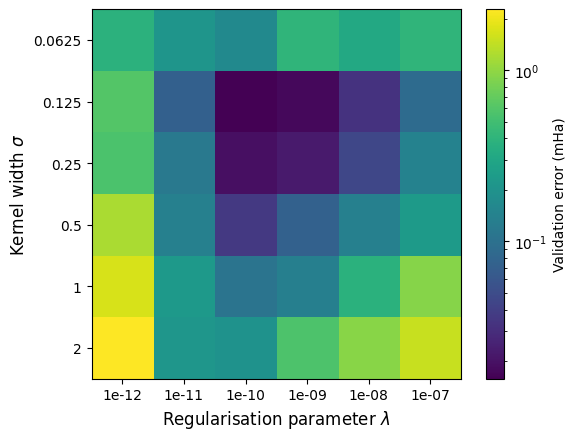

Best hyperparameters: regularisation_parameter = 1e-10, kernel_width = 0.125
Mean test error over 10 repeats: 9.193059077265235e-06 mHa
Mean test error across folds: 1.3368753003452208e-05 pm 4.744551229948956e-06
Functional: F3[d3]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


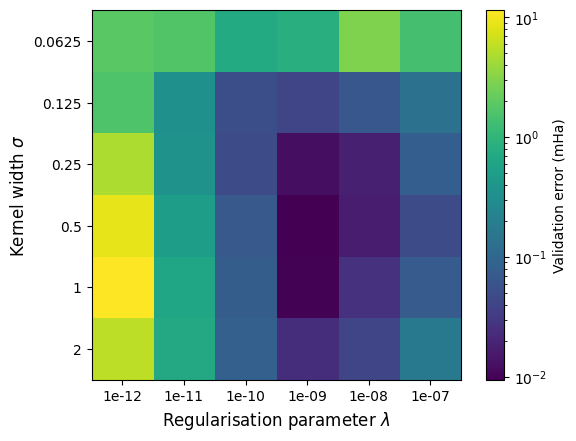

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 9.409465740987483e-06 mHa
Outer fold 2/6


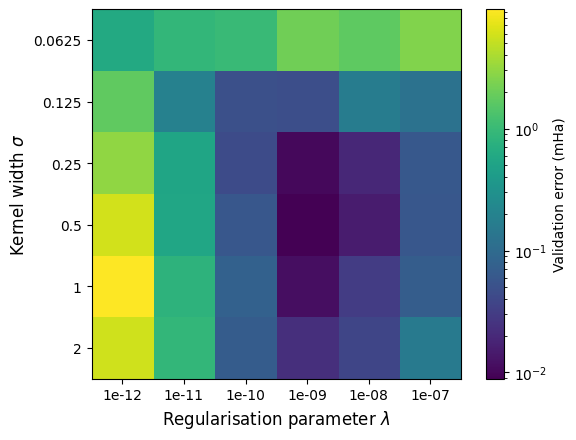

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 6.834681775691465e-06 mHa
Outer fold 3/6


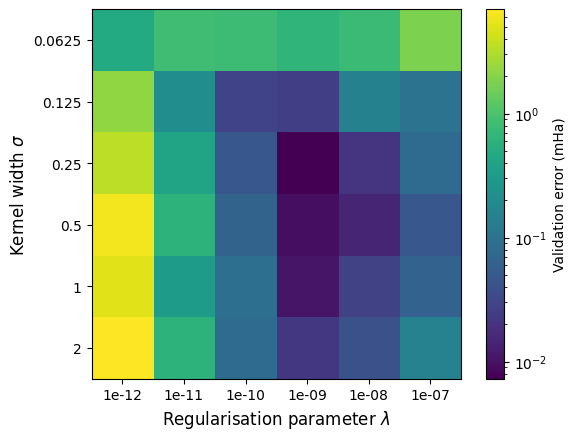

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 1.1598206407651784e-05 mHa
Outer fold 4/6


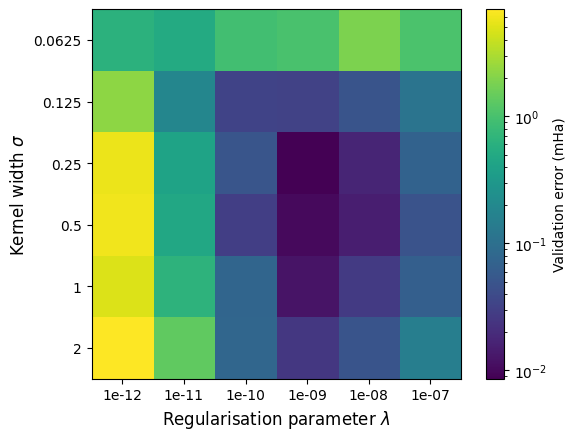

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 6.209696969650124e-06 mHa
Outer fold 5/6


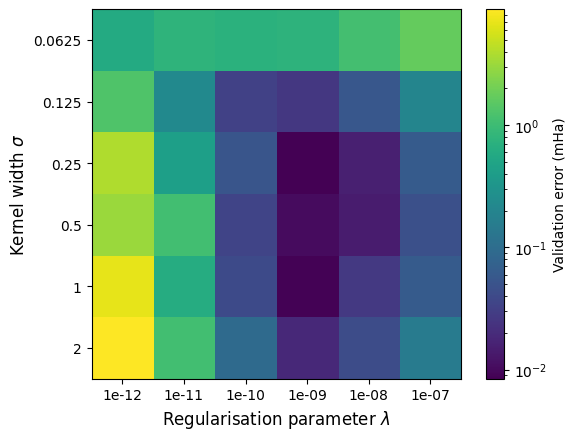

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.25
Mean test error over 10 repeats: 1.5569994805401476e-05 mHa
Outer fold 6/6


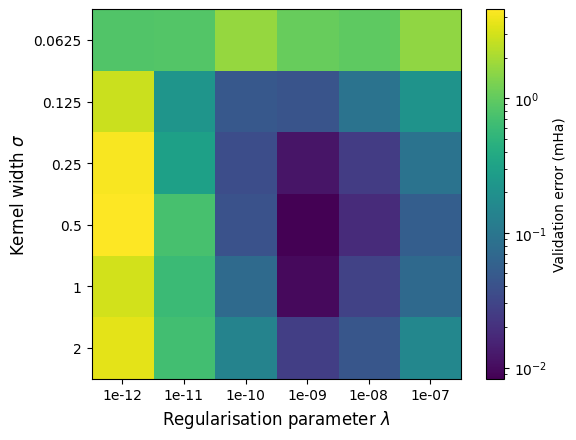

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 0.5
Mean test error over 10 repeats: 1.0671230059674148e-05 mHa
Mean test error across folds: 1.004887929317608e-05 pm 3.1291555774933676e-06
Functional: E3[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


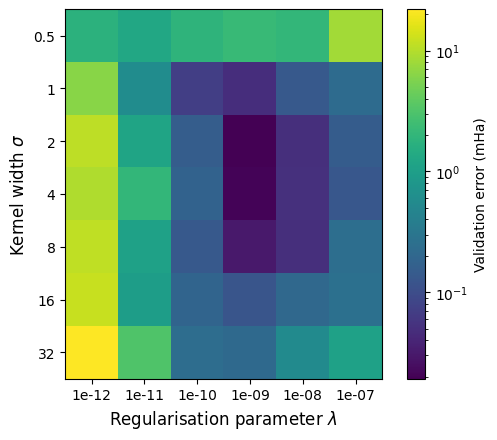

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.9723359046290116e-05 mHa
Outer fold 2/6


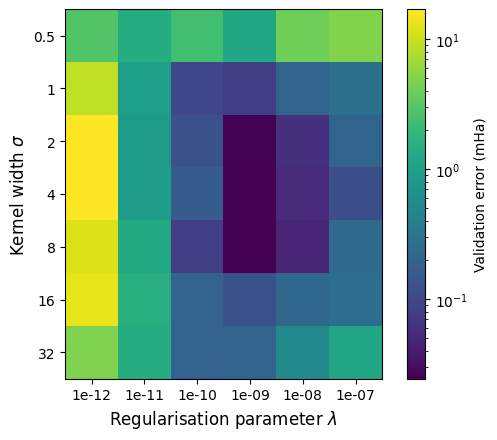

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 2.4668412701263814e-05 mHa
Outer fold 3/6


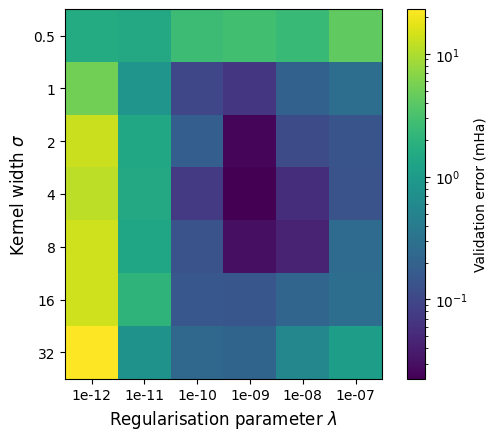

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.3873691910192288e-05 mHa
Outer fold 4/6


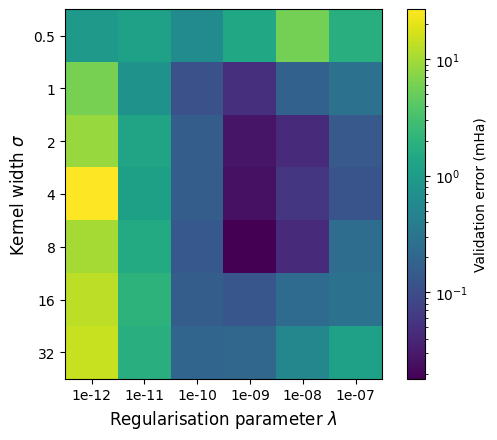

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 1.8838660462927592e-05 mHa
Outer fold 5/6


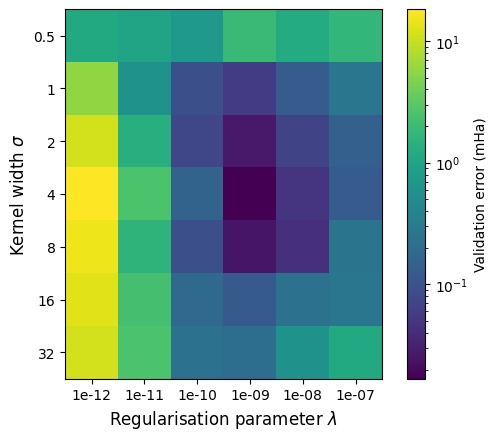

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 1.6091574493988974e-05 mHa
Outer fold 6/6


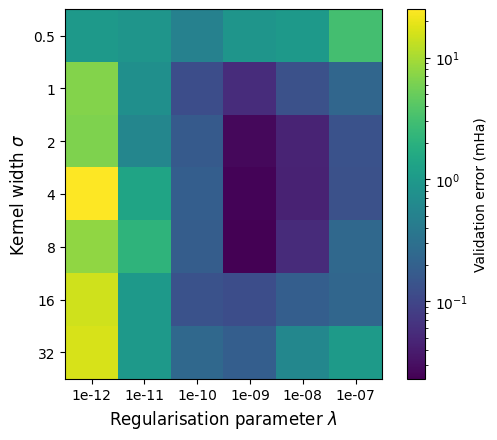

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 8.0
Mean test error over 10 repeats: 3.4270568013091324e-05 mHa
Mean test error across folds: 2.2911044437959017e-05 pm 5.863796110253117e-06
Functional: I3[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


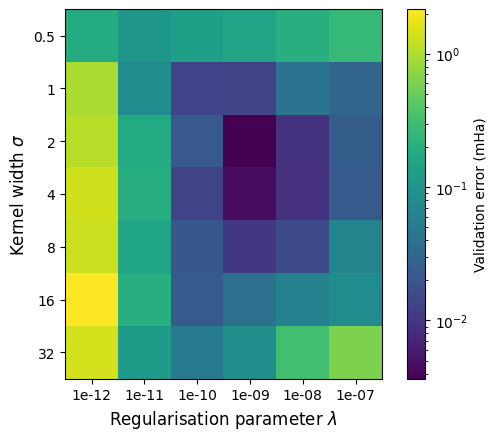

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 9.544141821319722e-06 mHa
Outer fold 2/6


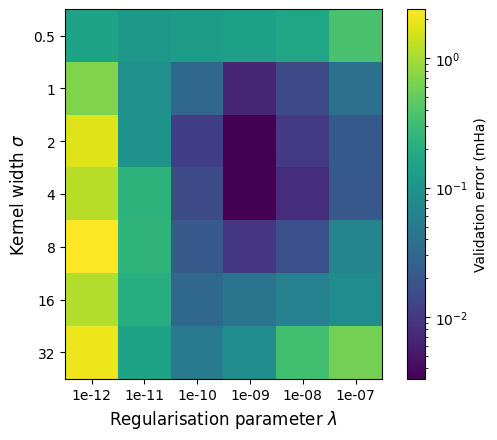

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.74921196382986e-06 mHa
Outer fold 3/6


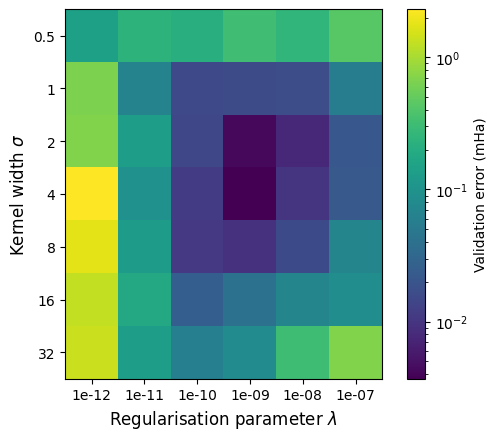

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 3.2601658916201854e-06 mHa
Outer fold 4/6


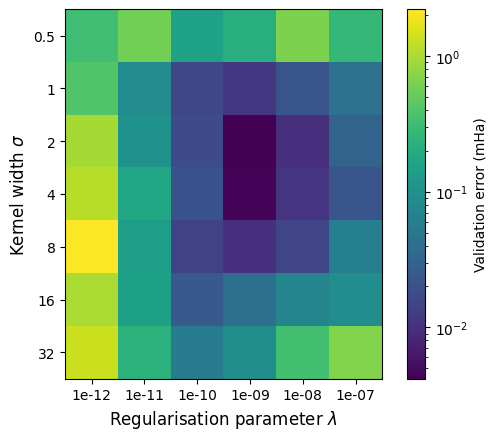

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 3.725598038880248e-06 mHa
Outer fold 5/6


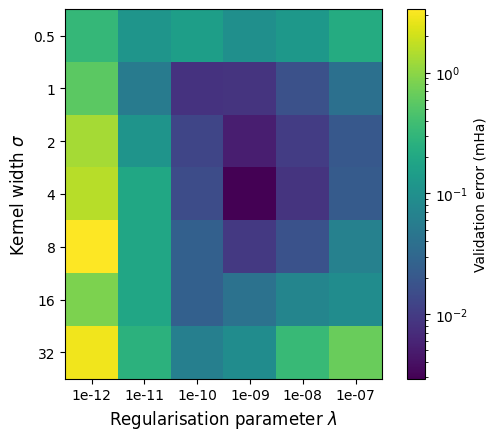

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 2.0827646720400498e-06 mHa
Outer fold 6/6


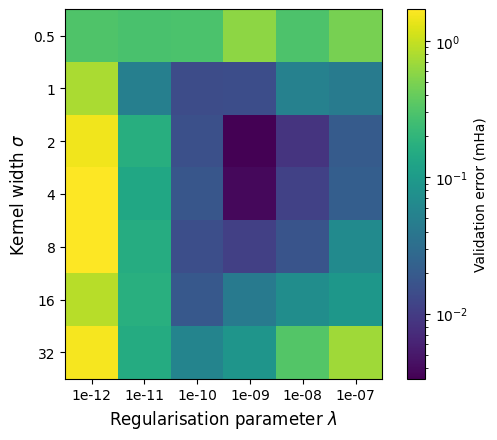

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 4.235927325568766e-06 mHa
Mean test error across folds: 4.2663016188764714e-06 pm 2.457321844439307e-06
Functional: F3[v]
n_train: 100, n_val: 20, n_test: 24
Outer fold 1/6


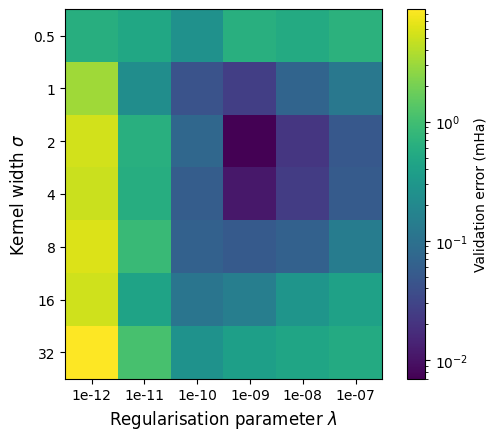

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 8.193787428430651e-06 mHa
Outer fold 2/6


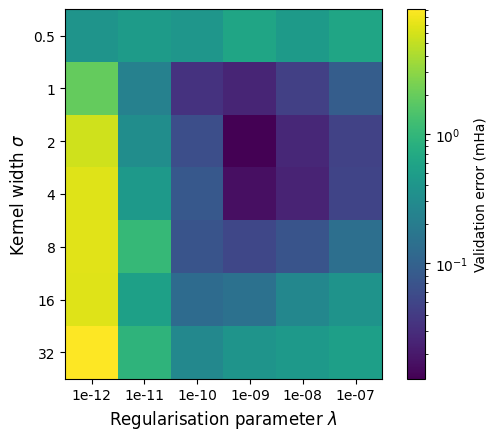

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 1.8654518448217118e-05 mHa
Outer fold 3/6


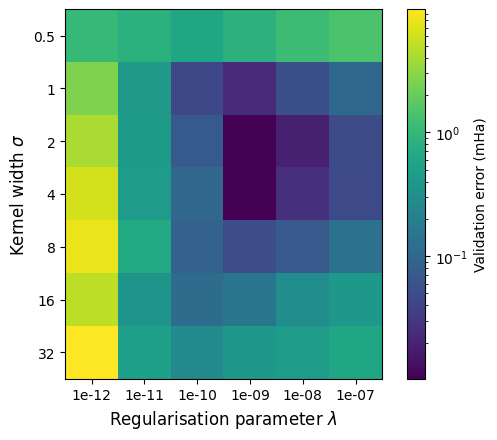

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 4.0
Mean test error over 10 repeats: 9.098372963426785e-06 mHa
Outer fold 4/6


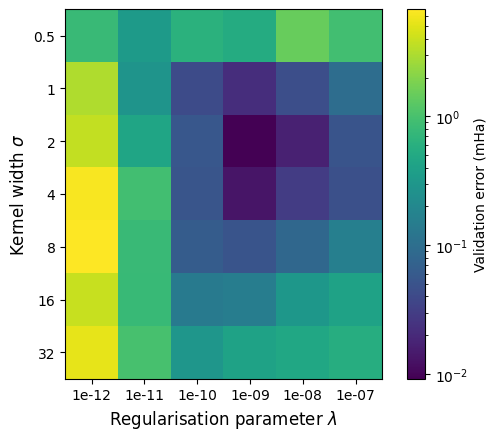

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 5.59989987621486e-06 mHa
Outer fold 5/6


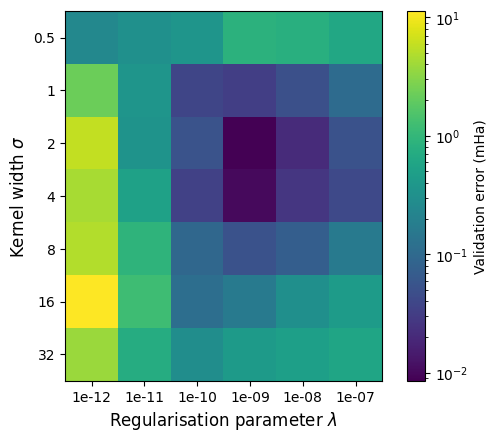

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 5.78059193983016e-06 mHa
Outer fold 6/6


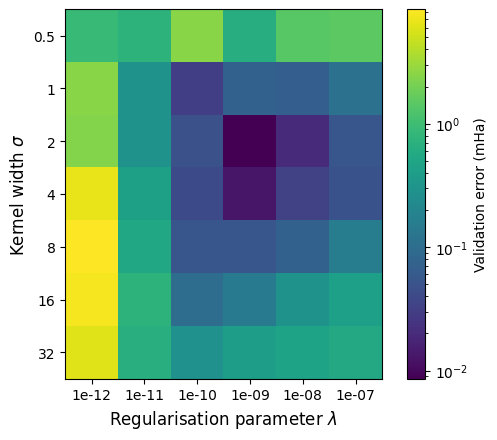

Best hyperparameters: regularisation_parameter = 1e-09, kernel_width = 2.0
Mean test error over 10 repeats: 8.138232808134008e-06 mHa
Mean test error across folds: 9.244233910708931e-06 pm 4.400367276361529e-06


In [ ]:
#tuning and testing all KRR functionals
n_outer_folds = 6 #number of test sets
n_inner_folds = 6 #number of training-validation splits for each test set
x = np.linspace(-6,6,65)
dx = x[1]-x[0]
for n_electrons in [1,2,3]:
    if n_electrons == 1:
        input_properties = ['d1','v']
        output_properties = ['E1','A1','F1','G1']
    elif n_electrons == 2:
        input_properties = ['d2','v']
        output_properties = ['E2','I2','A2','F2','G2']
    elif n_electrons == 3:
        input_properties = ['d3','v']
        output_properties = ['E3','I3','F3']
    else:
        raise ValueError("Invalid number of electrons")

    for input_property in input_properties:
        functional_type = 'density_functional'
        # Define the hyperparameter values for the grid searches. Different values are required for different input properties, e.g. potential functionals require larger kernel widths.
        if input_property == 'v':
            functional_type = 'potential_functional'
            kernel_widths = 2.0**np.arange(-1,6)
            regularisation_parameters = 10.0**np.arange(-12,-6)
        elif input_property == 'd1':
            kernel_widths = 2.0**np.arange(-6,1)
            regularisation_parameters = 10.0**np.arange(-12,-6)
        elif input_property == 'd2':
            kernel_widths = 2.0**np.arange(-5,2)
            regularisation_parameters = 10.0**np.arange(-13,-6)
        elif input_property == 'd3':
            kernel_widths = 2.0**np.arange(-4,2)
            regularisation_parameters = 10.0**np.arange(-12,-6)
        features = data[f'{input_property}']

        for output_property in output_properties:
            functional_label = f'{output_property}[{input_property}]'
            print("Functional:", functional_label)
            labels = data[f'{output_property}']

            maes, nmaes, noise_sensitivities, RKHS_norms = nested_k_fold_cross_val(features, labels, n_outer_folds, n_inner_folds, regularisation_parameters, kernel_widths, dx, n_repeats=10, verbose=2)
            results_dict[functional_type][functional_label] = {
                "mean_mae": np.mean(maes),
                "std_mae": np.std(maes),
                "mean_nmae": np.mean(nmaes),
                "std_nmae": np.std(nmaes),
                "mean_noise_sensitivity": np.mean(noise_sensitivities),
                "std_noise_sensitivity": np.std(noise_sensitivities),
                "mean_RKHS_norm": np.mean(RKHS_norms)
            }

In [ ]:
with open('results.json', 'w') as f:
    json.dump(results_dict, f)